<a href="https://colab.research.google.com/github/capchipcup/EnsembleUNet2D/blob/main/Ensemble_UNet2D_%5BnoTF%2CRGBImages%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Library**

In [ ]:
!pip install segmentation_models
!pip install pydicom

import tensorflow as tf
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras
import pydicom as dicom
from keras.utils import normalize
from keras.metrics import MeanIoU
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
from keras.models import load_model
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from pydicom import dcmread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tabulate import tabulate
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.
Mounted at /content/drive


**Input Images**

In [ ]:
#Images Setting
seed = 42
np.random.seed = seed
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

#Input Images
TRAIN_PATH = '/content/drive/MyDrive/SMT 7/Internship-AIDA/Dataset 2D UNet/stage1_train'
TEST_PATH = '/content/drive/MyDrive/SMT 7/Internship-AIDA/Dataset 2D UNet/stage1_test'
TRAIN_PATH_IMAGES = os.path.join(TRAIN_PATH, 'images')
TRAIN_PATH_MASKS = os.path.join(TRAIN_PATH, 'masks')
train_ids = os.listdir(TRAIN_PATH_IMAGES)
test_ids = os.listdir(TEST_PATH)

#Applying Images Setting
train_images = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
train_masks = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

#Transforming Images to Array
def dcm_to_array(dcm_path):
    ds = dcmread(dcm_path)
    return ds.pixel_array

#Resizing training images
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    # === image =====
    path = os.path.join(TRAIN_PATH_IMAGES, id_)
    common_id = id_[1:6]
    img = dcm_to_array(path)
    clahe = cv2.createCLAHE(clipLimit=3.5)
    img = clahe.apply(np.uint8(img*255))
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    train_images[n] = img.reshape((IMG_HEIGHT, IMG_WIDTH, 1))  #Fill empty train_images with values from img

    # === mask =====
    mask_file = f'liver_GT_{common_id}.png'
    mask_path = os.path.join(TRAIN_PATH_MASKS, mask_file)
    mask = imread(mask_path)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = mask.reshape((IMG_HEIGHT, IMG_WIDTH, 1))

    train_masks[n] = mask

# Resizing test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img = dcm_to_array(path)
    sizes_test.append([img.shape[0], img.shape[1]])
    clahe = cv2.createCLAHE(clipLimit=3.5)
    img = clahe.apply(np.uint8(img*255))
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    X_test[n] = img.reshape(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

print('Done!')

Resizing training images and masks


100%|██████████| 2874/2874 [11:07<00:00,  4.31it/s]


Resizing test images


100%|██████████| 78/78 [00:19<00:00,  3.99it/s]

Done!


**One Step Before the Model**

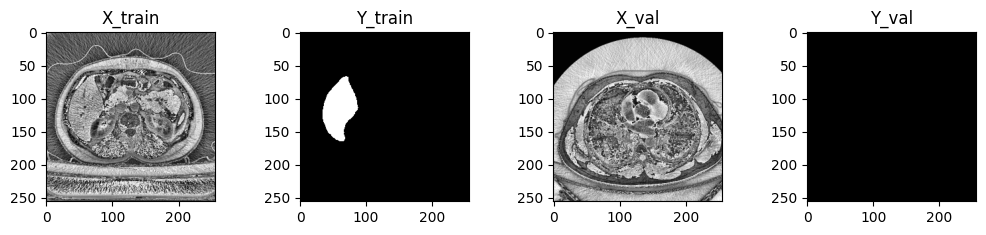

In [ ]:
#Training and Validation Splitting
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_masks, test_size = 0.25, random_state = 0)

#RGB Transform for Images
def grayscale_to_rgb(images):
    return np.repeat(images, 3, axis=-1)
X_train_rgb = grayscale_to_rgb(X_train)
X_val_rgb = grayscale_to_rgb(X_val)
X_test_rgb = grayscale_to_rgb(X_test)

#Array Transform for Masks
Y_train = Y_train.astype('float32')
Y_val = Y_val.astype('float32')

#Images Display
image_train = random.randint(0, len(X_train))
image_val = random.randint(0, len(X_val))

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].imshow(X_train[image_train], cmap = 'gray')
axes[0].set_title('X_train')
axes[1].imshow(Y_train[image_train, :, :, 0], cmap='gray')
axes[1].set_title('Y_train')
axes[2].imshow(X_val[image_val], cmap = 'gray')
axes[2].set_title('X_val')
axes[3].imshow(Y_val[image_val, :, :, 0], cmap='gray')
axes[3].set_title('Y_val')
plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
X_file = np.concatenate([X_train_rgb, X_val_rgb])
Y_file = np.concatenate([Y_train, Y_val])

**MODEL 1**

In [ ]:
#Images Preprocessing For Model 1
BACKBONE1 = 'vgg16'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

X_train1 = preprocess_input1(X_train_rgb)
X_val1 = preprocess_input1(X_val_rgb)
X_test1 = preprocess_input1(X_test_rgb)
X_file1 = preprocess_input1(X_file)

In [ ]:
#Evaluation Metrics
total_loss = sm.losses.DiceLoss() + (1*sm.losses.CategoricalFocalLoss())
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(),
    tf.keras.metrics.BinaryAccuracy(threshold=0.5),
    tf.keras.metrics.Precision(thresholds=0.5),
    tf.keras.metrics.Recall(thresholds=0.5),
    sm.losses.DiceLoss(),
    sm.losses.BinaryFocalLoss(),
    sm.losses.JaccardLoss(),
    total_loss,
]

#Hyperparameter Setting
activation='sigmoid'
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
model1 = sm.Unet(BACKBONE1, encoder_weights=None, activation=activation, input_shape=(None,None,3))
model1.compile(optim,
              loss=sm.losses.bce_jaccard_loss,
              metrics=metrics)
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nucleiVGG16.h5', verbose=1, save_best_only=True)
callbacks = [ tf.keras.callbacks.EarlyStopping(patience=125, monitor='val_loss'),
              tf.keras.callbacks.TensorBoard(log_dir='logs')]
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, None, None, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, None, None, 64)       0         ['block1_conv2[0][0]']        
                                                                                              

In [ ]:
#Model Training
results1 = model1.fit(X_train1, Y_train, batch_size=4, epochs=250, verbose=1, validation_data= (X_val1, Y_val),callbacks=callbacks)

Epoch 1/250
539/539 [==============================] - 50s 58ms/step - loss: 1.1055 - iou_score: 0.6144 - f1-score: 0.3396 - binary_accuracy: 0.9133 - precision: 0.4132 - recall: 0.9047 - dice_loss: 0.6604 - binary_focal_loss: 0.0540 - jaccard_loss: 0.7853 - dice_loss_plus_1focal_loss: 0.6615 - val_loss: 0.7116 - val_iou_score: 0.8178 - val_f1-score: 0.5414 - val_binary_accuracy: 0.9890 - val_precision: 0.9324 - val_recall: 0.8905 - val_dice_loss: 0.4586 - val_binary_focal_loss: 0.0067 - val_jaccard_loss: 0.6166 - val_dice_loss_plus_1focal_loss: 0.4607
Epoch 2/250
539/539 [==============================] - 26s 49ms/step - loss: 0.4787 - iou_score: 0.8430 - f1-score: 0.7197 - binary_accuracy: 0.9901 - precision: 0.9090 - recall: 0.9360 - dice_loss: 0.2803 - binary_focal_loss: 0.0113 - jaccard_loss: 0.4192 - dice_loss_plus_1focal_loss: 0.2822 - val_loss: 0.5409 - val_iou_score: 0.6576 - val_f1-score: 0.6890 - val_binary_accuracy: 0.9745 - val_precision: 0.7634 - val_recall: 0.8646 - val_

In [ ]:
model1.evaluate(X_file1, Y_file)

90/90 [==============================] - 15s 115ms/step - loss: 0.0157 - iou_score: 0.9908 - f1-score: 0.9952 - binary_accuracy: 0.9994 - precision: 0.9956 - recall: 0.9953 - dice_loss: 0.0048 - binary_focal_loss: 0.0023 - jaccard_loss: 0.0095 - dice_loss_plus_1focal_loss: 0.0055


[0.015738921239972115,
 0.9907764792442322,
 0.9951792359352112,
 0.9994223713874817,
 0.9955605864524841,
 0.9952527284622192,
 0.0048208944499492645,
 0.0023479931987822056,
 0.009533485397696495,
 0.0054718670435249805]

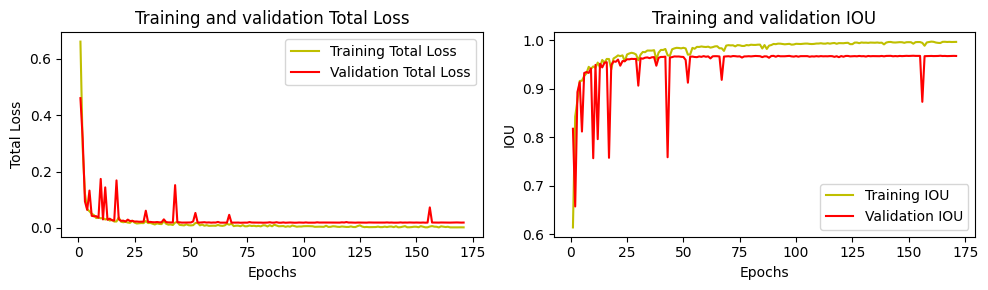

In [ ]:
# Create the figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(10,3))

# Plot the first set of graphs on the first axis
total_loss = results1.history['dice_loss_plus_1focal_loss']
val_total_loss = results1.history['val_dice_loss_plus_1focal_loss']
epochs = range(1, len(total_loss) + 1)

axes[0].plot(epochs, total_loss, 'y', label='Training Total Loss')
axes[0].plot(epochs, val_total_loss, 'r', label='Validation Total Loss')
axes[0].set_title('Training and validation Total Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Total Loss')
axes[0].legend()

# Plot the second set of graphs on the second axis
iou_score = results1.history['iou_score']
val_iou_score = results1.history['val_iou_score']

axes[1].plot(epochs, iou_score, 'y', label='Training IOU')
axes[1].plot(epochs, val_iou_score, 'r', label='Validation IOU')
axes[1].set_title('Training and validation IOU')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
model1.save('/content/drive/MyDrive/Colab Notebooks/Ensamble1/vgg16_sectryok_171epochs.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
preds_train = model1.predict(X_train_rgb, verbose=1)
preds_val = model1.predict(X_val_rgb, verbose=1)
preds_train1 = model1.predict(X_train1, verbose=1)
preds_val1 = model1.predict(X_val1, verbose=1)
preds_test = model1.predict(test_images_rgb, verbose=1)
preds_test1 = model1.predict(test_images1, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_train1_t = (preds_train1 > 0.5).astype(np.uint8)
preds_val1_t = (preds_val1 > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
preds_test1_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 60ms/step


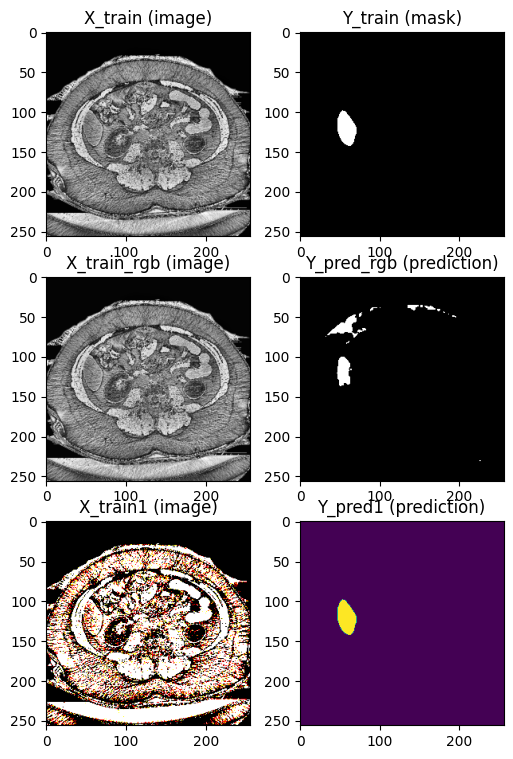

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
fig, axes = plt.subplots(3, 2, figsize=(6, 9), gridspec_kw={'height_ratios': [3, 3, 3]})

axes[0,0].imshow(X_train[ix], cmap='gray')
axes[0,0].set_title('X_train (image)')

axes[0,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
axes[0,1].set_title('Y_train (mask)')

axes[1,0].imshow(X_train_rgb[ix], cmap='gray')
axes[1,0].set_title('X_train_rgb (image)')

axes[1,1].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_rgb (prediction)')

axes[2,0].imshow(X_train1[ix], cmap='gray')
axes[2,0].set_title('X_train1 (image)')

axes[2,1].imshow(np.squeeze(preds_train1_t[ix]))
axes[2,1].set_title('Y_pred1 (prediction)')

plt.show()

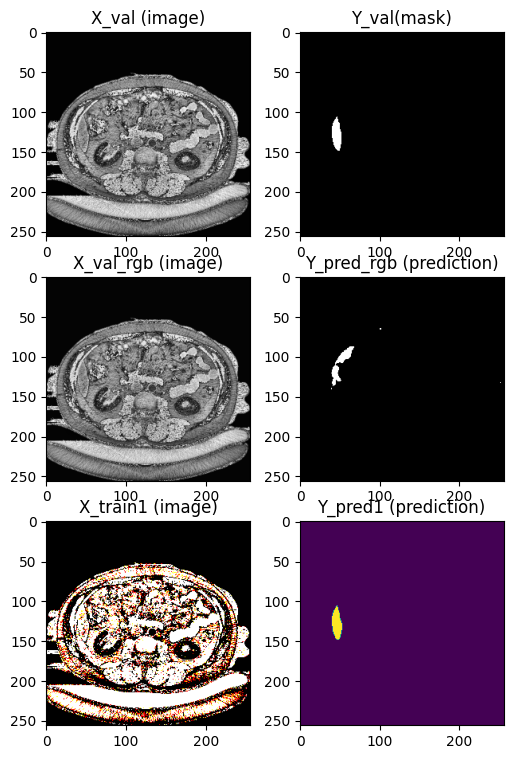

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
fig, axes = plt.subplots(3, 2, figsize=(6, 9), gridspec_kw={'height_ratios': [3, 3, 3]})

axes[0,0].imshow(X_val[ix], cmap='gray')
axes[0,0].set_title('X_val (image)')

axes[0,1].imshow(np.squeeze(Y_val[ix]), cmap='gray')
axes[0,1].set_title('Y_val(mask)')

axes[1,0].imshow(X_val_rgb[ix], cmap='gray')
axes[1,0].set_title('X_val_rgb (image)')

axes[1,1].imshow(np.squeeze(preds_val_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_rgb (prediction)')

axes[2,0].imshow(X_val1[ix], cmap='gray')
axes[2,0].set_title('X_train1 (image)')

axes[2,1].imshow(np.squeeze(preds_val1_t[ix]))
axes[2,1].set_title('Y_pred1 (prediction)')

plt.show()

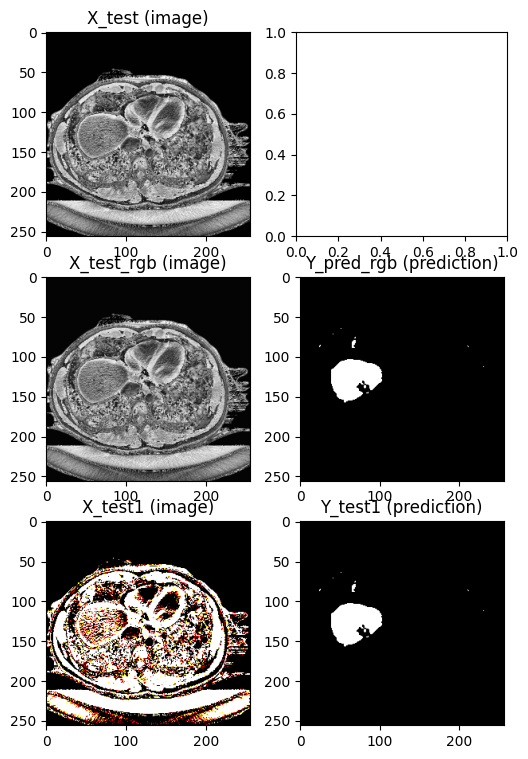

In [ ]:
# Perform a sanity check on some random testing samples
ix = random.randint(0, len(test_images))
fig, axes = plt.subplots(3, 2, figsize=(6, 9), gridspec_kw={'height_ratios': [3, 3, 3]})

axes[0,0].imshow(test_images[ix], cmap='gray')
axes[0,0].set_title('X_test (image)')

axes[1,0].imshow(test_images_rgb[ix], cmap='gray')
axes[1,0].set_title('X_test_rgb (image)')

axes[1,1].imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_rgb (prediction)')

axes[2,0].imshow(test_images1[ix])
axes[2,0].set_title('X_test1 (image)')

axes[2,1].imshow(np.squeeze(preds_test1_t[ix]), cmap='gray')
axes[2,1].set_title('Y_test1 (prediction)')

plt.show()

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
fig, axes = plt.subplots(1, 3)

axes[0].imshow(X_train[ix], cmap='gray')
axes[0].set_title('X_train (image)')

axes[1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
axes[1].set_title('Y_train (mask)')

axes[2].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')
axes[2].set_title('Y_pred (prediction)')

plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
fig, axes = plt.subplots(1, 3)

axes[0].imshow(X_val[ix], cmap='gray')
axes[0].set_title('X_val (image)')

axes[1].imshow(np.squeeze(Y_val[ix]), cmap='gray')
axes[1].set_title('Y_val(mask)')

axes[2].imshow(np.squeeze(preds_val_t[ix]), cmap='gray')
axes[2].set_title('Y_pred (prediction)')

plt.show()

In [ ]:
# Perform a sanity check on some random testing samples
ix = random.randint(0, len(test_images))
fig, axes = plt.subplots(1,2)

axes[0].imshow(test_images[ix], cmap='gray')
axes[0].set_title('X_test (images)')

axes[1].imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
axes[1].set_title('Y_pred(prediction)')

plt.show()

**MODEL 2**

In [ ]:
#Images Preprocessing For Model 2
BACKBONE2 = 'resnet152'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

X_train2 = preprocess_input2(X_train_rgb)
X_val2 = preprocess_input2(X_val_rgb)
X_test2 = preprocess_input2(X_test_rgb)
X_file2 = preprocess_input2(X_file)

In [ ]:
#Evaluation Metrics
total_loss = sm.losses.DiceLoss() + (1*sm.losses.CategoricalFocalLoss())
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(),
    tf.keras.metrics.BinaryAccuracy(threshold=0.5),
    tf.keras.metrics.Precision(thresholds=0.5),
    tf.keras.metrics.Recall(thresholds=0.5),
    sm.losses.DiceLoss(),
    sm.losses.BinaryFocalLoss(),
    sm.losses.JaccardLoss(),
    total_loss,
]

#Hyperparameter Setting
activation='sigmoid'
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
model2 = sm.Unet(BACKBONE2, encoder_weights=None, activation=activation, input_shape=(None,None,3))
model2.compile(optim,
              loss=sm.losses.bce_jaccard_loss,
              metrics=metrics)
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nucleiRES152.h5', verbose=1, save_best_only=True)
callbacks = [ tf.keras.callbacks.EarlyStopping(patience=125, monitor='val_loss'),
              tf.keras.callbacks.TensorBoard(log_dir='logs')]
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [ ]:
results2 = model2.fit(X_train2, Y_train, batch_size=4, epochs=200, verbose=1, validation_data= (X_val2, Y_val),callbacks=callbacks)

Epoch 1/200
539/539 [==============================] - 152s 127ms/step - loss: 1.0122 - iou_score: 0.5215 - f1-score: 0.3714 - binary_accuracy: 0.9262 - precision_1: 0.4527 - recall_1: 0.8337 - dice_loss: 0.6286 - binary_focal_loss: 0.0414 - jaccard_loss: 0.7577 - dice_loss_plus_1focal_loss: 0.6309 - val_loss: 0.8550 - val_iou_score: 0.4966 - val_f1-score: 0.5115 - val_binary_accuracy: 0.9475 - val_precision_1: 0.5556 - val_recall_1: 0.8419 - val_dice_loss: 0.4885 - val_binary_focal_loss: 0.0930 - val_jaccard_loss: 0.6419 - val_dice_loss_plus_1focal_loss: 0.4962
Epoch 2/200
539/539 [==============================] - 64s 119ms/step - loss: 0.4543 - iou_score: 0.7471 - f1-score: 0.7450 - binary_accuracy: 0.9829 - precision_1: 0.8566 - recall_1: 0.8745 - dice_loss: 0.2550 - binary_focal_loss: 0.0191 - jaccard_loss: 0.3912 - dice_loss_plus_1focal_loss: 0.2596 - val_loss: 0.2846 - val_iou_score: 0.8312 - val_f1-score: 0.8511 - val_binary_accuracy: 0.9904 - val_precision_1: 0.9536 - val_reca

In [ ]:
model2.evaluate(X_file2, Y_file)

90/90 [==============================] - 13s 130ms/step - loss: 0.0175 - iou_score: 0.9894 - f1-score: 0.9944 - binary_accuracy: 0.9993 - precision_1: 0.9952 - recall_1: 0.9942 - dice_loss: 0.0056 - binary_focal_loss: 0.0024 - jaccard_loss: 0.0111 - dice_loss_plus_1focal_loss: 0.0063


[0.01748216524720192,
 0.989359438419342,
 0.9943968057632446,
 0.9993321299552917,
 0.9951843619346619,
 0.9941930174827576,
 0.005603222642093897,
 0.0023644310422241688,
 0.011081822216510773,
 0.006319537293165922]

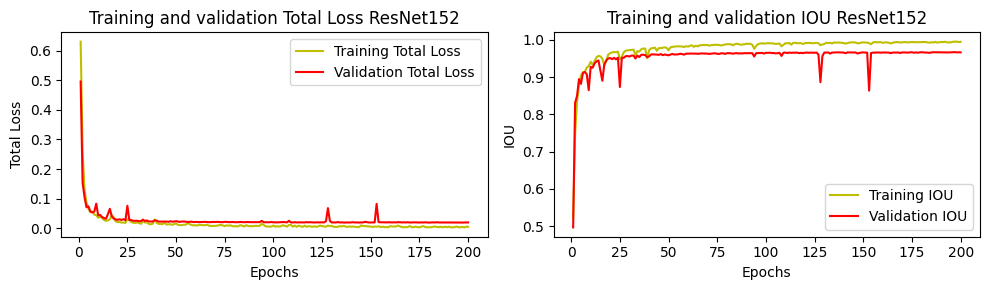

In [ ]:
# Create the figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(10,3))

# Plot the first set of graphs on the first axis
total_loss2 = results2.history['dice_loss_plus_1focal_loss']
val_total_loss2 = results2.history['val_dice_loss_plus_1focal_loss']
epochs = range(1, len(total_loss2) + 1)

axes[0].plot(epochs, total_loss2, 'y', label='Training Total Loss')
axes[0].plot(epochs, val_total_loss2, 'r', label='Validation Total Loss')
axes[0].set_title('Training and validation Total Loss ResNet152')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Total Loss')
axes[0].legend()

# Plot the second set of graphs on the second axis
iou_score2 = results2.history['iou_score']
val_iou_score2 = results2.history['val_iou_score']

axes[1].plot(epochs, iou_score2, 'y', label='Training IOU')
axes[1].plot(epochs, val_iou_score2, 'r', label='Validation IOU')
axes[1].set_title('Training and validation IOU ResNet152')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
preds_train2 = model2.predict(X_train2, verbose=1)
preds_val2 = model2.predict(X_val2, verbose=1)
preds_test2 = model2.predict(test_images2, verbose=1)

preds_train2_t = (preds_train2 > 0.5).astype(np.uint8)
preds_val2_t = (preds_val2 > 0.5).astype(np.uint8)
preds_test2_t = (preds_test2 > 0.5).astype(np.uint8)

3/3 [==============================] - 4s 2s/step


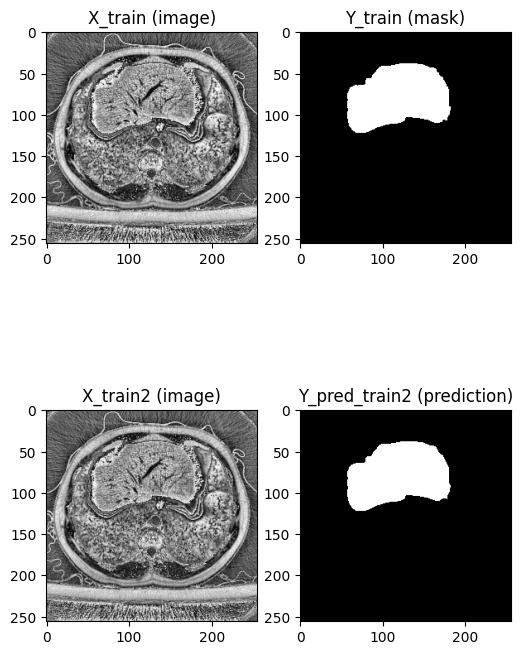

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train2_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9),
                         #gridspec_kw={'height_ratios': [3, 3, 3]}
                         )

axes[0,0].imshow(X_train[ix], cmap='gray')
axes[0,0].set_title('X_train (image)')

axes[0,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
axes[0,1].set_title('Y_train (mask)')

axes[1,0].imshow(X_train2[ix])
axes[1,0].set_title('X_train2 (image)')

axes[1,1].imshow(np.squeeze(preds_train2_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_train2 (prediction)')

plt.show()

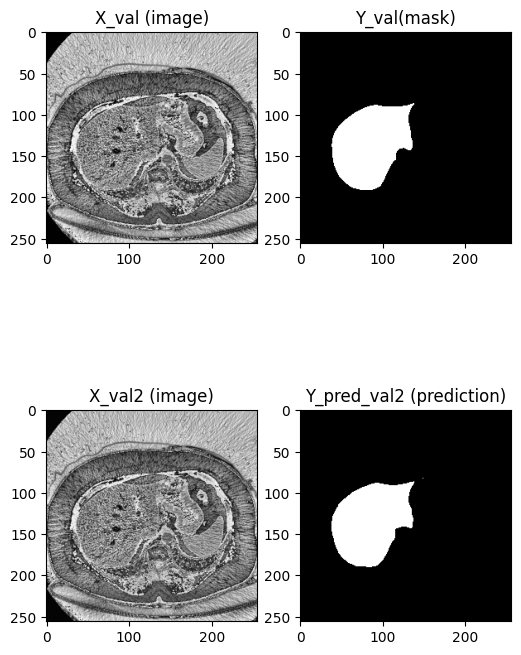

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val2_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(X_val[ix], cmap='gray')
axes[0,0].set_title('X_val (image)')

axes[0,1].imshow(np.squeeze(Y_val[ix]), cmap='gray')
axes[0,1].set_title('Y_val(mask)')

axes[1,0].imshow(X_val2[ix], cmap='gray')
axes[1,0].set_title('X_val2 (image)')

axes[1,1].imshow(np.squeeze(preds_val2_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_val2 (prediction)')

plt.show()

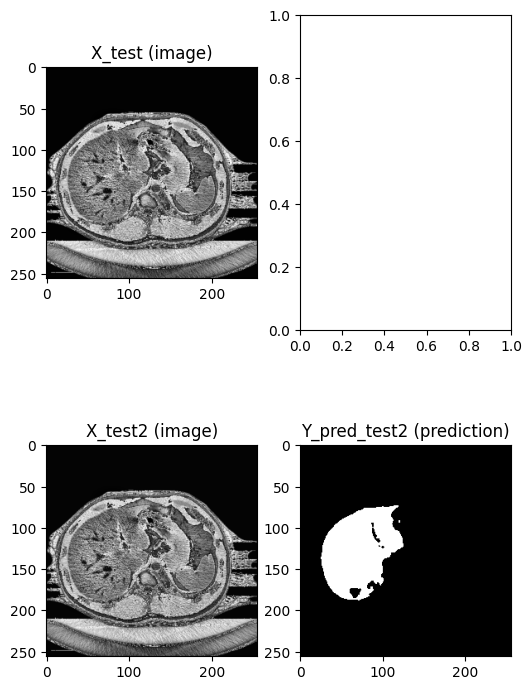

In [ ]:
# Perform a sanity check on some random testing samples
ix = random.randint(0, len(preds_test2_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(test_images[ix], cmap='gray')
axes[0,0].set_title('X_test (image)')

axes[1,0].imshow(test_images2[ix], cmap='gray')
axes[1,0].set_title('X_test2 (image)')

axes[1,1].imshow(np.squeeze(preds_test2_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_test2 (prediction)')

plt.show()

In [ ]:
model2.save('/content/drive/MyDrive/Colab Notebooks/Ensamble1/res152_sectrynotok_backbone_200epochs.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**MODEL 3**

In [ ]:
BACKBONE3 = 'resnet34'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

X_train3 = preprocess_input3(X_train_rgb)
X_val3 = preprocess_input3(X_val_rgb)
X_test3 = preprocess_input3(X_test_rgb)
X_file3 = preprocess_input3(X_file)

In [ ]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(), sm.losses.DiceLoss(), sm.losses.BinaryFocalLoss(), sm.losses.JaccardLoss()]

activation='sigmoid'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=125, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]

model3 = sm.Unet(BACKBONE3, encoder_weights=None, activation=activation, input_shape=(None,None,3))
model3.compile(optim, loss=sm.losses.bce_jaccard_loss,metrics=metrics)
model3.summary()

results3 = model3.fit(X_train3, Y_train, batch_size=4, epochs=200, verbose=1, validation_data= (X_val3, Y_val),callbacks=callbacks)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

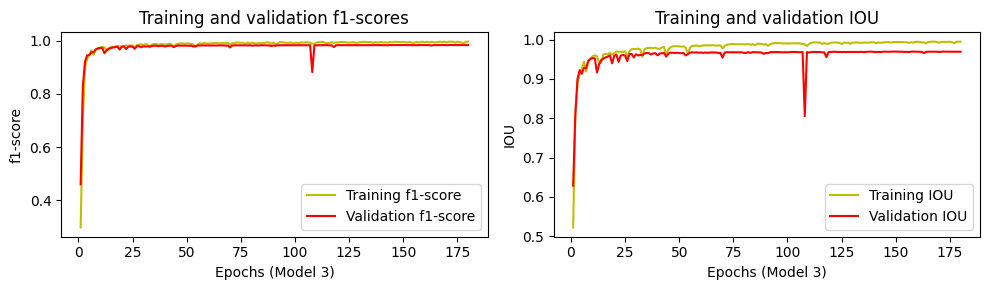

In [ ]:
# Create the figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(10,3))

# Plot the first set of graphs on the first axis
f1score = results3.history['f1-score']
val_f1score = results3.history['val_f1-score']
epochs = range(1, len(f1score) + 1)

axes[0].plot(epochs, f1score, 'y', label='Training f1-score')
axes[0].plot(epochs, val_f1score, 'r', label='Validation f1-score')
axes[0].set_title('Training and validation f1-scores')
axes[0].set_xlabel('Epochs (Model 3)')
axes[0].set_ylabel('f1-score')
axes[0].legend()

# Plot the second set of graphs on the second axis
iou_score = results3.history['iou_score']
val_iou_score = results3.history['val_iou_score']

axes[1].plot(epochs, iou_score, 'y', label='Training IOU')
axes[1].plot(epochs, val_iou_score, 'r', label='Validation IOU')
axes[1].set_title('Training and validation IOU')
axes[1].set_xlabel('Epochs (Model 3)')
axes[1].set_ylabel('IOU')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
preds_train3 = model3.predict(X_train3, verbose=1)
preds_val3 = model3.predict(X_val3, verbose=1)
preds_test3 = model3.predict(test_images3, verbose=1)

preds_train3_t = (preds_train3 > 0.5).astype(np.uint8)
preds_val3_t = (preds_val3 > 0.5).astype(np.uint8)
preds_test3_t = (preds_test3 > 0.5).astype(np.uint8)

3/3 [==============================] - 2s 1s/step


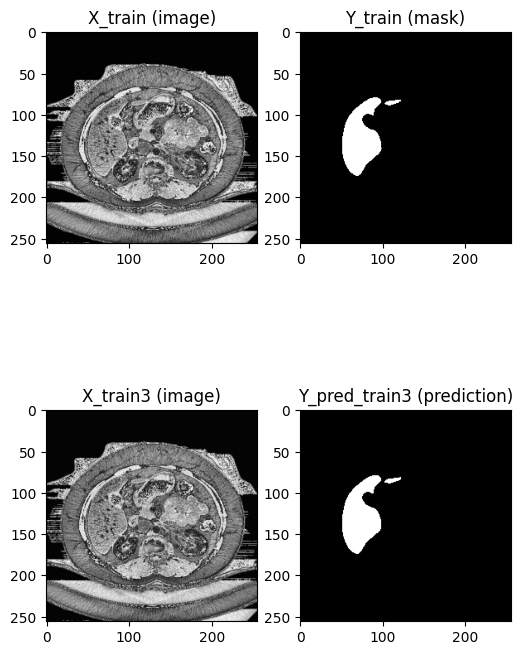

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train3_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(X_train[ix], cmap='gray')
axes[0,0].set_title('X_train (image)')

axes[0,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
axes[0,1].set_title('Y_train (mask)')

axes[1,0].imshow(X_train3[ix])
axes[1,0].set_title('X_train3 (image)')

axes[1,1].imshow(np.squeeze(preds_train3_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_train3 (prediction)')

plt.show()

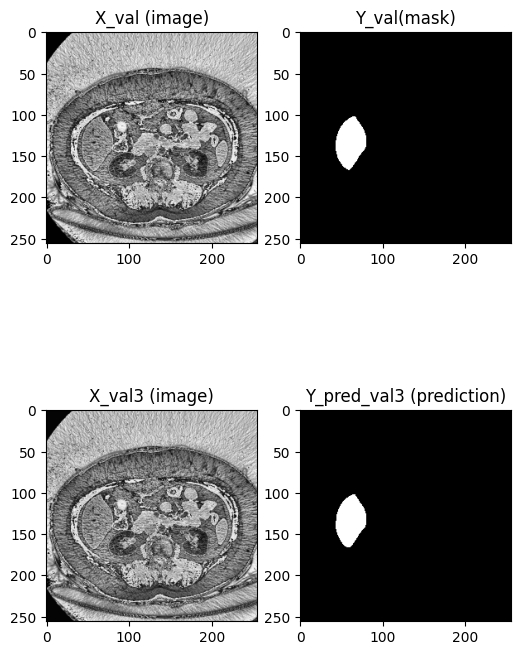

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val3_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(X_val[ix], cmap='gray')
axes[0,0].set_title('X_val (image)')

axes[0,1].imshow(np.squeeze(Y_val[ix]), cmap='gray')
axes[0,1].set_title('Y_val(mask)')

axes[1,0].imshow(X_val3[ix], cmap='gray')
axes[1,0].set_title('X_val3 (image)')

axes[1,1].imshow(np.squeeze(preds_val3_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_val3 (prediction)')

plt.show()

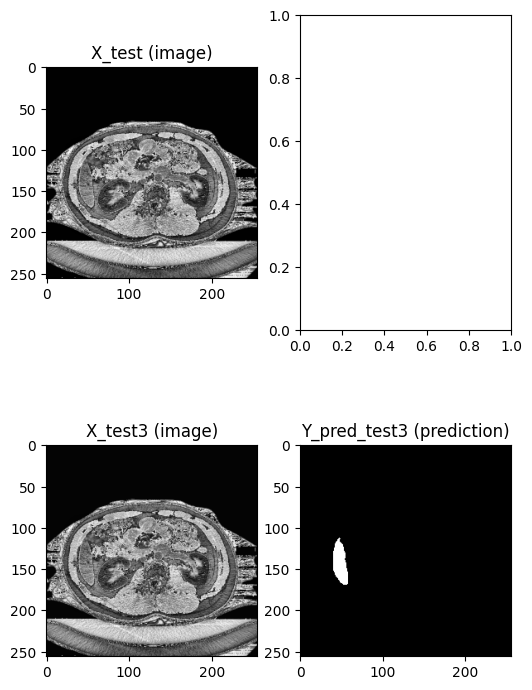

In [ ]:
# Perform a sanity check on some random testing samples
ix = random.randint(0, len(preds_test3_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(test_images[ix], cmap='gray')
axes[0,0].set_title('X_test (image)')

axes[1,0].imshow(test_images3[ix], cmap='gray')
axes[1,0].set_title('X_test3 (image)')

axes[1,1].imshow(np.squeeze(preds_test3_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_test3 (prediction)')

plt.show()

In [ ]:
model3.save('/content/drive/MyDrive/Colab Notebooks/Ensamble1/res34__firsttryoknotok_backbone_180epochs.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**MODEL 4**

In [ ]:
#Evaluation Metrics
total_loss = sm.losses.DiceLoss() + (1*sm.losses.CategoricalFocalLoss())
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(),
    tf.keras.metrics.BinaryAccuracy(threshold=0.5),
    tf.keras.metrics.Precision(thresholds=0.5),
    tf.keras.metrics.Recall(thresholds=0.5),
    sm.losses.DiceLoss(),
    sm.losses.BinaryFocalLoss(),
    sm.losses.JaccardLoss(),
    total_loss,
]

#Hyperparameter Setting
activation='sigmoid'
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
model4 = sm.Unet(encoder_weights=None, activation=activation, input_shape=(None,None,3))
model4.compile(optim,
              loss=sm.losses.bce_jaccard_loss,
              metrics=metrics)
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nucleiUNET.h5', verbose=1, save_best_only=True)
callbacks = [ tf.keras.callbacks.EarlyStopping(patience=125, monitor='val_loss'),
              tf.keras.callbacks.TensorBoard(log_dir='logs')]
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, None, None, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, None, None, 64)       0         ['block1_conv2[0][0]']        
                                                                                              

In [ ]:
results4 = model4.fit(X_train_rgb, Y_train, batch_size=4, epochs=200, verbose=1, validation_data= (X_val_rgb, Y_val),callbacks=callbacks)

Epoch 1/200
539/539 [==============================] - 114s 165ms/step - loss: 0.7575 - iou_score: 0.6644 - f1-score: 0.5343 - binary_accuracy: 0.9694 - precision: 0.7142 - recall: 0.8551 - dice_loss: 0.4657 - binary_focal_loss: 0.0250 - jaccard_loss: 0.6089 - dice_loss_plus_1focal_loss: 0.4686 - val_loss: 0.9118 - val_iou_score: 0.2871 - val_f1-score: 0.3606 - val_binary_accuracy: 0.9562 - val_precision: 0.9912 - val_recall: 0.3084 - val_dice_loss: 0.6394 - val_binary_focal_loss: 0.0241 - val_jaccard_loss: 0.7725 - val_dice_loss_plus_1focal_loss: 0.6634
Epoch 2/200
539/539 [==============================] - 81s 150ms/step - loss: 0.3006 - iou_score: 0.8210 - f1-score: 0.8412 - binary_accuracy: 0.9889 - precision: 0.9155 - recall: 0.9078 - dice_loss: 0.1588 - binary_focal_loss: 0.0130 - jaccard_loss: 0.2603 - dice_loss_plus_1focal_loss: 0.1628 - val_loss: 0.3839 - val_iou_score: 0.7254 - val_f1-score: 0.7999 - val_binary_accuracy: 0.9840 - val_precision: 0.9868 - val_recall: 0.7566 - v

In [ ]:
model4.evaluate(X_file,Y_file)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))

f1score4 = results4.history['f1-score']
val_f1score4 = results4.history['val_f1-score']
epochs4 = range(1, len(f1score) + 1)

axes[0].plot(epochs4, f1score4, 'y', label='Training f1-score')
axes[0].plot(epochs4, val_f1score4, 'r', label='Validation f1-score')
axes[0].set_title('Training and validation f1-scores UNet')
axes[0].set_xlabel('Epochs (Model 4)')
axes[0].set_ylabel('f1-score')
axes[0].legend()

iou_score4 = results4.history['iou_score']
val_iou_score4 = results4.history['val_iou_score']

axes[1].plot(epochs4, iou_score4, 'y', label='Training IOU')
axes[1].plot(epochs4, val_iou_score4, 'r', label='Validation IOU')
axes[1].set_title('Training and validation IOU UNet')
axes[1].set_xlabel('Epochs (Model 4)')
axes[1].set_ylabel('IOU')
axes[1].legend()

loss4 = results4.history['loss']
loss4 = results4.history['val_loss']

axes[1].plot(epochs4, iou_score4, 'y', label='Training Loss')
axes[1].plot(epochs4, val_iou_score4, 'r', label='Validation Loss')
axes[1].set_title('Training and validation Loss UNet')
axes[1].set_xlabel('Epochs (Model 4)')
axes[1].set_ylabel('IOU')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
preds_train4 = model4.predict(X_train_rgb, verbose=1)
preds_val4 = model4.predict(X_val_rgb, verbose=1)
preds_test4 = model4.predict(test_images_rgb, verbose=1)

preds_train4_t = (preds_train4 > 0.5).astype(np.uint8)
preds_val4_t = (preds_val4 > 0.5).astype(np.uint8)
preds_test4_t = (preds_test4 > 0.5).astype(np.uint8)

3/3 [==============================] - 4s 2s/step


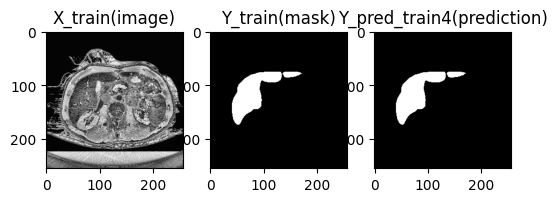

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train4_t))
fig, axes = plt.subplots(1, 3, figsize=(6, 9))

axes[0].imshow(X_train_rgb[ix], cmap='gray')
axes[0].set_title('X_train(image)')

axes[1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
axes[1].set_title('Y_train(mask)')

axes[2].imshow(np.squeeze(preds_train4_t[ix]), cmap='gray')
axes[2].set_title('Y_pred_train4(prediction)')

plt.show()

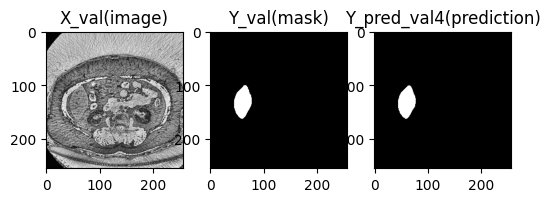

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val3_t))
fig, axes = plt.subplots(1, 3, figsize=(6, 9))

axes[0].imshow(X_val_rgb[ix], cmap='gray')
axes[0].set_title('X_val(image)')

axes[1].imshow(np.squeeze(Y_val[ix]), cmap='gray')
axes[1].set_title('Y_val(mask)')

axes[2].imshow(np.squeeze(preds_val4_t[ix]), cmap='gray')
axes[2].set_title('Y_pred_val4(prediction)')

plt.show()

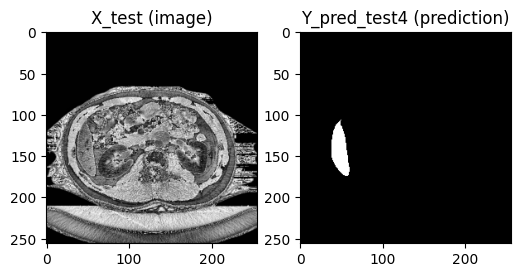

In [ ]:
# Perform a sanity check on some random testing samples
ix = random.randint(0, len(preds_test3_t))
fig, axes = plt.subplots(1, 2, figsize=(6, 9))

axes[0].imshow(test_images[ix], cmap='gray')
axes[0].set_title('X_test (image)')

axes[1].imshow(np.squeeze(preds_test4_t[ix]), cmap='gray')
axes[1].set_title('Y_pred_test4 (prediction)')

plt.show()

In [ ]:
model4.save('/content/drive/MyDrive/Colab Notebooks/Ensamble1/nobackbone_3rdtryoknotok_194epochs.hdf5')

**MODEL 5**

In [ ]:
#Images Preprocessing For Model 3
BACKBONE3 = 'mobilenetv2'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

X_train3 = preprocess_input3(X_train_rgb)
X_val3 = preprocess_input3(X_val_rgb)
X_test3 = preprocess_input3(X_test_rgb)
X_file3 = preprocess_input3(X_file)

In [ ]:
#Evaluation Metrics
total_loss = sm.losses.DiceLoss() + (1*sm.losses.CategoricalFocalLoss())
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(),
    tf.keras.metrics.BinaryAccuracy(threshold=0.5),
    tf.keras.metrics.Precision(thresholds=0.5),
    tf.keras.metrics.Recall(thresholds=0.5),
    sm.losses.DiceLoss(),
    sm.losses.BinaryFocalLoss(),
    sm.losses.JaccardLoss(),
    total_loss,
]

#Hyperparameter Setting
activation='sigmoid'
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
model3 = sm.Unet(BACKBONE3, encoder_weights=None, activation=activation, input_shape=(None,None,3))
model3.compile(optim,
               loss=sm.losses.bce_jaccard_loss,
               metrics=metrics)
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nucleimobilenetv2(2).h5', verbose=1, save_best_only=True)
callbacks = [ tf.keras.callbacks.EarlyStopping(patience=125, monitor='val_loss'),
              tf.keras.callbacks.TensorBoard(log_dir='logs')]
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['Conv1_pad[0][0]']           
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                        

In [ ]:
results3 = model3.fit(X_train3, Y_train, batch_size=4, epochs=200, verbose=1, validation_data= (X_val3, Y_val),callbacks=callbacks)

Epoch 1/200
539/539 [==============================] - 56s 50ms/step - loss: 0.9806 - iou_score: 0.4563 - f1-score: 0.3868 - binary_accuracy: 0.9327 - precision_2: 0.4775 - recall_2: 0.7602 - dice_loss: 0.6132 - binary_focal_loss: 0.0467 - jaccard_loss: 0.7476 - dice_loss_plus_1focal_loss: 0.6171 - val_loss: 1.2330 - val_iou_score: 1.0200e-09 - val_f1-score: 0.0373 - val_binary_accuracy: 0.9369 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_dice_loss: 0.9627 - val_binary_focal_loss: 0.0525 - val_jaccard_loss: 0.9810 - val_dice_loss_plus_1focal_loss: 1.0152
Epoch 2/200
539/539 [==============================] - 24s 44ms/step - loss: 0.5806 - iou_score: 0.6148 - f1-score: 0.6629 - binary_accuracy: 0.9704 - precision_2: 0.7539 - recall_2: 0.7856 - dice_loss: 0.3371 - binary_focal_loss: 0.0293 - jaccard_loss: 0.4887 - dice_loss_plus_1focal_loss: 0.3445 - val_loss: 1.3501 - val_iou_score: 1.0200e-09 - val_f1-score: 0.0072 - val_binary_accuracy: 0.9369 - val_precision_2: 0.00

In [ ]:
model3.evaluate(X_file3, Y_file)

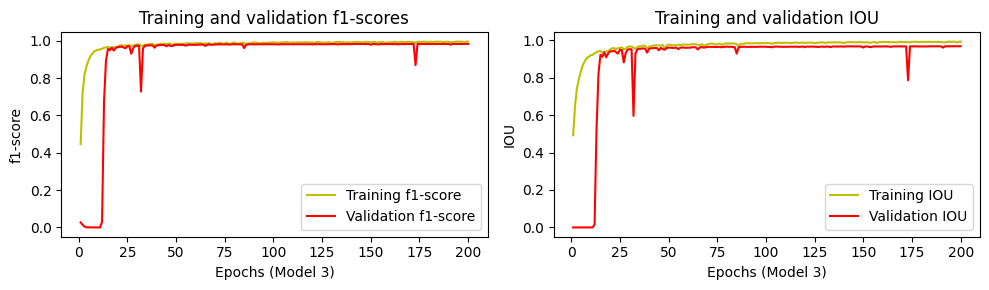

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))

# Plot the first set of graphs on the first axis
total_loss3 = results3.history['dice_loss_plus_1focal_loss']
val_total_loss3 = results3.history['val_dice_loss_plus_1focal_loss']
epochs3 = range(1, len(total_loss3) + 1)

axes[0].plot(epochs3, total_loss3, 'y', label='Training Total Loss')
axes[0].plot(epochs3, val_total_loss3, 'r', label='Validation Total Loss')
axes[0].set_title('Training and validation Total Loss MobileNetV2')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Total Loss')
axes[0].legend()

iou_score3 = results3.history['iou_score']
val_iou_score3 = results3.history['val_iou_score']

axes[1].plot(epochs3, iou_score3, 'y', label='Training IOU')
axes[1].plot(epochs3, val_iou_score3, 'r', label='Validation IOU')
axes[1].set_title('Training and validation IOU MobileNetV2')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU')
axes[1].legend()

loss3 = results3.history['loss']
val_loss3 = results3.history['val_loss']

axes[2].plot(epochs3, loss3, 'y', label='Training Loss')
axes[2].plot(epochs3, loss3, 'r', label='Validation Loss')
axes[2].set_title('Training and Validation Loss MobileNetV2')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('loss')
axes[2].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
preds_train3 = model3.predict(X_train3, verbose=1)
preds_val3 = model3.predict(X_val3, verbose=1)
preds_test3 = model3.predict(X_test3, verbose=1)

preds_train3_t = (preds_train3 > 0.5).astype(np.uint8)
preds_val3_t = (preds_val3 > 0.5).astype(np.uint8)
preds_test3_t = (preds_test3 > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 689ms/step


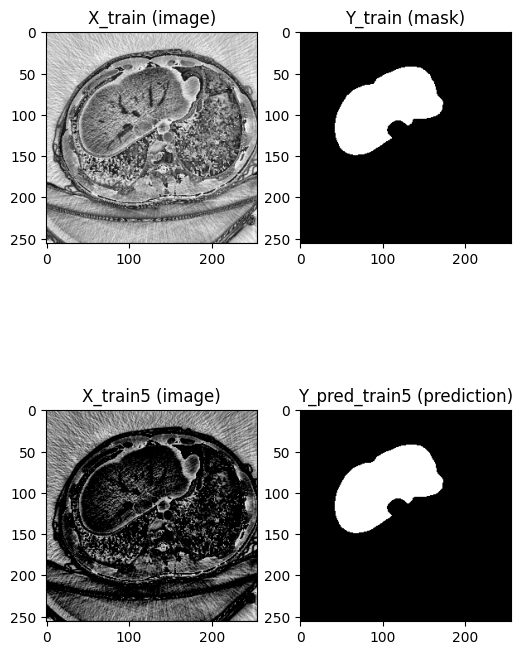

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train3_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(X_train[ix], cmap='gray')
axes[0,0].set_title('X_train (image)')

axes[0,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
axes[0,1].set_title('Y_train (mask)')

axes[1,0].imshow(X_train3[ix])
axes[1,0].set_title('X_train5 (image)')

axes[1,1].imshow(np.squeeze(preds_train3_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_train5 (prediction)')

plt.show()

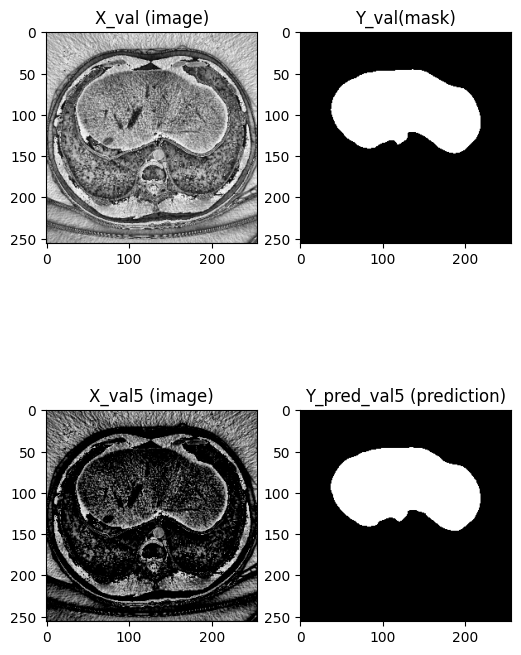

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val3_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(X_val[ix], cmap='gray')
axes[0,0].set_title('X_val (image)')

axes[0,1].imshow(np.squeeze(Y_val[ix]), cmap='gray')
axes[0,1].set_title('Y_val(mask)')

axes[1,0].imshow(X_val3[ix], cmap='gray')
axes[1,0].set_title('X_val5 (image)')

axes[1,1].imshow(np.squeeze(preds_val3_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_val5 (prediction)')

plt.show()

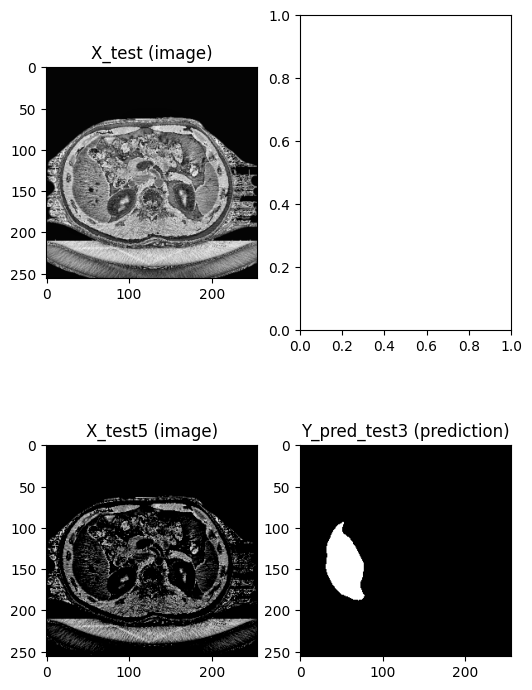

In [ ]:
# Perform a sanity check on some random testing samples
ix = random.randint(0, len(preds_test3_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(X_test_rgb[ix], cmap='gray')
axes[0,0].set_title('X_test (image)')

axes[1,0].imshow(X_test3[ix], cmap='gray')
axes[1,0].set_title('X_test5 (image)')

axes[1,1].imshow(np.squeeze(preds_test3_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_test3 (prediction)')

plt.show()

In [ ]:
model3.evaluate(X_file3, Y_file)

90/90 [==============================] - 6s 66ms/step - loss: 0.0179 - iou_score: 0.9880 - f1-score: 0.9936 - dice_loss: 0.0064 - binary_focal_loss: 0.0020 - jaccard_loss: 0.0127


[0.017910070717334747,
 0.9880411624908447,
 0.9936063289642334,
 0.006393390242010355,
 0.001989770447835326,
 0.012659411877393723]

In [ ]:
model3.save('/content/drive/MyDrive/Colab Notebooks/Ensamble1/mobnetv2_sectryok_backbone_200epochs.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**MODEL 6**

In [ ]:
BACKBONE6 = 'inceptionresnetv2'
preprocess_input6 = sm.get_preprocessing(BACKBONE6)

X_train6 = preprocess_input6(X_train_rgb)
X_val6 = preprocess_input6(X_val_rgb)
test_images6 = preprocess_input6(test_images_rgb)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(), sm.losses.DiceLoss(), sm.losses.BinaryFocalLoss(), sm.losses.JaccardLoss()]

activation='sigmoid'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=125, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='logs')]

model6 = sm.Unet(BACKBONE5, encoder_weights=None, activation=activation, input_shape=(None,None,3))
model6.compile(optim, loss=sm.losses.bce_jaccard_loss,metrics=metrics)
model6.summary()

results6 = model6.fit(X_train6, Y_train, batch_size=4, epochs=200, verbose=1, validation_data= (X_val6, Y_val),callbacks=callbacks)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['Conv1_pad[0][0]']           
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                        

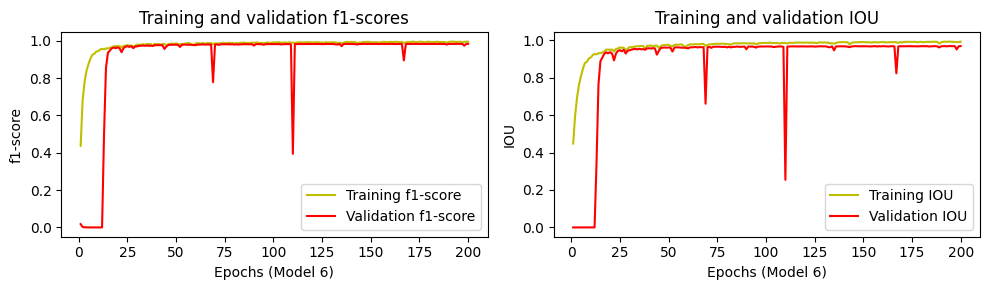

In [ ]:
# Create the figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(10,3))

# Plot the first set of graphs on the first axis
f1score = results6.history['f1-score']
val_f1score = results6.history['val_f1-score']
epochs = range(1, len(f1score) + 1)

axes[0].plot(epochs, f1score, 'y', label='Training f1-score')
axes[0].plot(epochs, val_f1score, 'r', label='Validation f1-score')
axes[0].set_title('Training and validation f1-scores')
axes[0].set_xlabel('Epochs (Model 6)')
axes[0].set_ylabel('f1-score')
axes[0].legend()

# Plot the second set of graphs on the second axis
iou_score = results6.history['iou_score']
val_iou_score = results6.history['val_iou_score']

axes[1].plot(epochs, iou_score, 'y', label='Training IOU')
axes[1].plot(epochs, val_iou_score, 'r', label='Validation IOU')
axes[1].set_title('Training and validation IOU')
axes[1].set_xlabel('Epochs (Model 6)')
axes[1].set_ylabel('IOU')
axes[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
preds_train6 = model6.predict(X_train6, verbose=1)
preds_val6 = model6.predict(X_val6, verbose=1)
preds_test6 = model6.predict(test_images6, verbose=1)

preds_train6_t = (preds_train6 > 0.5).astype(np.uint8)
preds_val6_t = (preds_val6 > 0.5).astype(np.uint8)
preds_test6_t = (preds_test6 > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 116ms/step


In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train6_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(X_train[ix], cmap='gray')
axes[0,0].set_title('X_train (image)')

axes[0,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
axes[0,1].set_title('Y_train (mask)')

axes[1,0].imshow(X_train6[ix])
axes[1,0].set_title('X_train6 (image)')

axes[1,1].imshow(np.squeeze(preds_train6_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_train6 (prediction)')

plt.show()

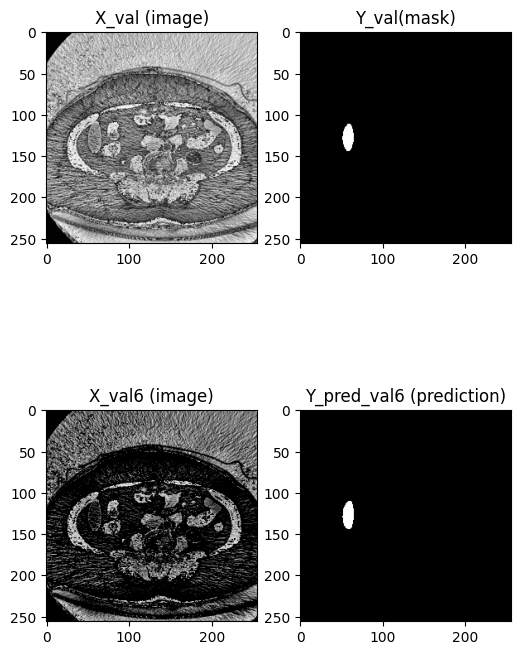

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val6_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(X_val[ix], cmap='gray')
axes[0,0].set_title('X_val (image)')

axes[0,1].imshow(np.squeeze(Y_val[ix]), cmap='gray')
axes[0,1].set_title('Y_val(mask)')

axes[1,0].imshow(X_val6[ix], cmap='gray')
axes[1,0].set_title('X_val6 (image)')

axes[1,1].imshow(np.squeeze(preds_val6_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_val6 (prediction)')

plt.show()

In [ ]:
# Perform a sanity check on some random testing samples
ix = random.randint(0, len(preds_test6_t))
fig, axes = plt.subplots(2, 2, figsize=(6, 9))

axes[0,0].imshow(test_images[ix], cmap='gray')
axes[0,0].set_title('X_test (image)')

axes[1,0].imshow(test_images6[ix], cmap='gray')
axes[1,0].set_title('X_test6 (image)')

axes[1,1].imshow(np.squeeze(preds_test6_t[ix]), cmap='gray')
axes[1,1].set_title('Y_pred_test6 (prediction)')

plt.show()

In [ ]:
model6.save('/content/drive/MyDrive/Colab Notebooks/Ensamble1/mobnetv2_firsttryNOTok_backbone_200epochs.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**ENSEMBLE UNET MODEL**

**IoU Score**

In [ ]:
def calculate_iou_set(masks1, masks2):
    if masks1.shape != masks2.shape:
        raise ValueError("Input arrays must have the same shape")

    num_masks = masks1.shape[0]
    iou_scores = []

    for i in range(num_masks):
        mask1 = masks1[i]
        mask2 = masks2[i]

        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        iou = np.sum(intersection) / np.sum(union)
        iou_scores.append(iou)

    return np.array(iou_scores)

In [ ]:
def calculate_iou_set(masks1, masks2):
    if masks1.shape != masks2.shape:
        raise ValueError("Input arrays must have the same shape")

    num_masks = masks1.shape[0]
    iou_scores = []

    for i in range(num_masks):
        mask1 = masks1[i]
        mask2 = masks2[i]

        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        iou = np.sum(intersection) / np.sum(union)
        iou_scores.append(iou)

    iou_scores = np.array(iou_scores)
    sum_of_IOU_05 = np.sum(iou_scores[iou_scores > 0.5])
    count_IOU_05 = np.sum(iou_scores > 0.5)
    average_IOU_05 = sum_of_IOU_05 / count_IOU_05 if count_IOU_05 > 0 else 0

    return np.array(iou_scores[iou_scores > 0.5])

In [ ]:
###INI YANG DIGUNAKAN
def calculate_iou_set(masks1, masks2, threshold=0.5):
    if masks1.shape != masks2.shape:
        raise ValueError("Input arrays must have the same shape")

    num_masks = masks1.shape[0]
    iou_scores = []

    iou_metric = sm.metrics.IOUScore(threshold=threshold)

    for i in range(num_masks):
        mask1 = masks1[i:i+1]
        mask2 = masks2[i:i+1]

        iou = iou_metric(mask1, mask2).numpy()
        iou_scores.append(iou)

    return np.array(iou_scores)

**Dice Score**

In [ ]:
def calculate_dsc_set(masks1, masks2):
    if masks1.shape != masks2.shape:
        raise ValueError("Input arrays must have the same shape")

    num_masks = masks1.shape[0]
    dice_scores = []

    for i in range(num_masks):
        mask1 = masks1[i]
        mask2 = masks2[i]

        intersection = np.sum(np.logical_and(mask1, mask2))
        union = np.sum(np.logical_or(mask1, mask2))

        # Calculate Dice score
        dice = (2.0 * intersection) / (union + intersection)

        dice_scores.append(dice)

    return np.array(dice_scores)

In [ ]:
def calculate_dsc_set(masks1, masks2):
    if masks1.shape != masks2.shape:
        raise ValueError("Input arrays must have the same shape")

    num_masks = masks1.shape[0]
    dice_scores = []

    for i in range(num_masks):
        mask1 = masks1[i]
        mask2 = masks2[i]

        intersection = np.sum(np.logical_and(mask1, mask2))
        union = np.sum(np.logical_or(mask1, mask2))

        # Calculate Dice score
        dice = (2.0 * intersection) / (union + intersection)

        dice_scores.append(dice)

    dice_scores = np.array(dice_scores)

    # Sum the Dice scores greater than 0.5
    sum_of_scores_gt_05 = np.sum(dice_scores[dice_scores > 0.5])

    # Count the number of Dice scores greater than 0.5
    count_gt_05 = np.sum(dice_scores > 0.5)

    # Calculate the average of Dice scores greater than 0.5
    average_gt_05 = sum_of_scores_gt_05 / count_gt_05 if count_gt_05 > 0 else 0

    return average_gt_05

In [ ]:
###INI YANG DIGUNAKAN
def calculate_dsc_set(masks1, masks2):
    if masks1.shape != masks2.shape:
        raise ValueError("Input arrays must have the same shape")

    num_masks = masks1.shape[0]
    dice_scores = []

    for i in range(num_masks):
        mask1 = masks1[i]
        mask2 = masks2[i]

        intersection = np.sum(np.logical_and(mask1, mask2))
        union = np.sum(np.logical_or(mask1, mask2))

        # Calculate Dice score
        dice = (2.0 * intersection) / (union + intersection)

        dice_scores.append(dice)

    dice_scores = np.array(dice_scores)
    return np.array(dice_scores[dice_scores > 0.5])

**Precision, Recall, F1 Score, Accuracy**

In [ ]:
precision_metric = tf.keras.metrics.Precision(thresholds=0.5)
total_precision = 0
count_above_threshold_p = 0

acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
total_acc = 0
count_above_threshold_a = 0

rec_metric = tf.keras.metrics.Recall(thresholds=0.5)
total_rec = 0
count_above_threshold_r = 0

# Iterate through your data
for i in range(len(Y_file)):
    y_pred_sample = weighted_train_predsall12[i:i+1]
    y_true_sample = Y_file[i:i+1]

    # Update metrics
    precision_metric.update_state(y_true_sample, y_pred_sample)
    acc_metric.update_state(y_true_sample, y_pred_sample)
    rec_metric.update_state(y_true_sample, y_pred_sample)

    # Check if value is above the threshold
    if precision_metric.result().numpy() > 0.5:
        total_precision += precision_metric.result().numpy()
        count_above_threshold_p += 1

    if acc_metric.result().numpy() > 0.5:
        total_acc += acc_metric.result().numpy()
        count_above_threshold_a += 1

    if rec_metric.result().numpy() > 0.5:
        total_rec += rec_metric.result().numpy()
        count_above_threshold_r += 1

# Calculate mean precision for samples above the threshold
mean_precision_value12 = total_precision / max(1, count_above_threshold_p)
mean_acc_value12 = total_acc / max(1, count_above_threshold_a)
mean_rec_value12 = total_rec / max(1, count_above_threshold_r)

print(f"Mean Precision: {mean_precision_value12}")
print(f"Mean Acc: {mean_acc_value12}")
print(f"Mean Rec: {mean_rec_value12}")
print(f"Mean F1: {2*mean_rec_value12*mean_precision_value12/(mean_rec_value12+mean_precision_value12)}")

Mean Precision: 0.9985259722402383
Mean Acc: 0.9997692866796575
Mean Rec: 0.9977881399267816
Mean F1: 0.9981569197330931


In [ ]:
precision_metric = tf.keras.metrics.Precision(thresholds=0.5)
total_precision = 0
count_above_threshold_p = 0

acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
total_acc = 0
count_above_threshold_a = 0

rec_metric = tf.keras.metrics.Recall(thresholds=0.5)
total_rec = 0
count_above_threshold_r = 0

# Iterate through your data
for i in range(len(Y_file)):
    y_pred_sample = weighted_train_predsall13[i:i+1]
    y_true_sample = Y_file[i:i+1]

    # Update metrics
    precision_metric.update_state(y_true_sample, y_pred_sample)
    acc_metric.update_state(y_true_sample, y_pred_sample)
    rec_metric.update_state(y_true_sample, y_pred_sample)

    # Check if value is above the threshold
    if precision_metric.result().numpy() > 0.5:
        total_precision += precision_metric.result().numpy()
        count_above_threshold_p += 1

    if acc_metric.result().numpy() > 0.5:
        total_acc += acc_metric.result().numpy()
        count_above_threshold_a += 1

    if rec_metric.result().numpy() > 0.5:
        total_rec += rec_metric.result().numpy()
        count_above_threshold_r += 1

# Calculate mean precision for samples above the threshold
mean_precision_value13 = total_precision / max(1, count_above_threshold_p)
mean_acc_value13 = total_acc / max(1, count_above_threshold_a)
mean_rec_value13 = total_rec / max(1, count_above_threshold_r)

print(f"Mean Precision: {mean_precision_value13}")
print(f"Mean Acc: {mean_acc_value13}")
print(f"Mean Rec: {mean_rec_value13}")
print(f"Mean F1: {2*mean_rec_value13*mean_precision_value13/(mean_rec_value13+mean_precision_value13)}")

Mean Precision: 0.9985259722402383
Mean Acc: 0.9997692866796575
Mean Rec: 0.9977881399267816
Mean F1: 0.9981569197330931


In [ ]:
precision_metric = tf.keras.metrics.Precision(thresholds=0.5)
total_precision = 0
count_above_threshold_p = 0

acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
total_acc = 0
count_above_threshold_a = 0

rec_metric = tf.keras.metrics.Recall(thresholds=0.5)
total_rec = 0
count_above_threshold_r = 0

# Iterate through your data
for i in range(len(Y_file)):
    y_pred_sample = weighted_train_predsall23[i:i+1]
    y_true_sample = Y_file[i:i+1]

    # Update metrics
    precision_metric.update_state(y_true_sample, y_pred_sample)
    acc_metric.update_state(y_true_sample, y_pred_sample)
    rec_metric.update_state(y_true_sample, y_pred_sample)

    # Check if value is above the threshold
    if precision_metric.result().numpy() > 0.5:
        total_precision += precision_metric.result().numpy()
        count_above_threshold_p += 1

    if acc_metric.result().numpy() > 0.5:
        total_acc += acc_metric.result().numpy()
        count_above_threshold_a += 1

    if rec_metric.result().numpy() > 0.5:
        total_rec += rec_metric.result().numpy()
        count_above_threshold_r += 1

# Calculate mean precision for samples above the threshold
mean_precision_value23 = total_precision / max(1, count_above_threshold_p)
mean_acc_value23 = total_acc / max(1, count_above_threshold_a)
mean_rec_value23 = total_rec / max(1, count_above_threshold_r)

print(f"Mean Precision: {mean_precision_value23}")
print(f"Mean Acc: {mean_acc_value23}")
print(f"Mean Rec: {mean_rec_value23}")
print(f"Mean F1: {2*mean_rec_value23*mean_precision_value23/(mean_rec_value23+mean_precision_value23)}")

Mean Precision: 0.9985191573180834
Mean Acc: 0.9996799450204368
Mean Rec: 0.9963552903905044
Mean F1: 0.9974360502666313


In [ ]:
precision_metric = tf.keras.metrics.Precision(thresholds=0.5)
total_precision = 0
count_above_threshold_p = 0

acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
total_acc = 0
count_above_threshold_a = 0

rec_metric = tf.keras.metrics.Recall(thresholds=0.5)
total_rec = 0
count_above_threshold_r = 0

# Iterate through your data
for i in range(len(Y_file)):
    y_pred_sample = weighted_train_predsall[i:i+1]
    y_true_sample = Y_file[i:i+1]

    # Update metrics
    precision_metric.update_state(y_true_sample, y_pred_sample)
    acc_metric.update_state(y_true_sample, y_pred_sample)
    rec_metric.update_state(y_true_sample, y_pred_sample)

    # Check if value is above the threshold
    if precision_metric.result().numpy() > 0.5:
        total_precision += precision_metric.result().numpy()
        count_above_threshold_p += 1

    if acc_metric.result().numpy() > 0.5:
        total_acc += acc_metric.result().numpy()
        count_above_threshold_a += 1

    if rec_metric.result().numpy() > 0.5:
        total_rec += rec_metric.result().numpy()
        count_above_threshold_r += 1

# Calculate mean precision for samples above the threshold
mean_precision_value123 = total_precision / max(1, count_above_threshold_p)
mean_acc_value123 = total_acc / max(1, count_above_threshold_a)
mean_rec_value123 = total_rec / max(1, count_above_threshold_r)
mean_f1s_value123 = 2*mean_rec_value123*mean_precision_value123/(mean_rec_value123+mean_precision_value123)

print(f"Mean Precision: {mean_precision_value23}")
print(f"Mean Acc: {mean_acc_value23}")
print(f"Mean Rec: {mean_rec_value23}")
print(f"Mean F1: {mean_f1s_value123}")

Mean Precision: 0.9985191573180834
Mean Acc: 0.9996799450204368
Mean Rec: 0.9963552903905044
Mean F1: 0.9981569197330931


In [ ]:
precision_metric = tf.keras.metrics.Precision(thresholds=0.5)
total_precision = 0
count_above_threshold_p = 0

acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
total_acc = 0
count_above_threshold_a = 0

rec_metric = tf.keras.metrics.Recall(thresholds=0.5)
total_rec = 0
count_above_threshold_r = 0

# Iterate through your data
for i in range(len(Y_file)):
    y_pred_sample = preds_all4_t[i:i+1]
    y_true_sample = Y_file[i:i+1]

    # Update metrics
    precision_metric.update_state(y_true_sample, y_pred_sample)
    acc_metric.update_state(y_true_sample, y_pred_sample)
    rec_metric.update_state(y_true_sample, y_pred_sample)

    # Check if value is above the threshold
    if precision_metric.result().numpy() > 0.5:
        total_precision += precision_metric.result().numpy()
        count_above_threshold_p += 1

    if acc_metric.result().numpy() > 0.5:
        total_acc += acc_metric.result().numpy()
        count_above_threshold_a += 1

    if rec_metric.result().numpy() > 0.5:
        total_rec += rec_metric.result().numpy()
        count_above_threshold_r += 1

# Calculate mean precision for samples above the threshold
mean_precision_value4 = total_precision / max(1, count_above_threshold_p)
mean_acc_value4 = total_acc / max(1, count_above_threshold_a)
mean_rec_value4 = total_rec / max(1, count_above_threshold_r)

print(f"Mean Precision: {mean_precision_value4}")
print(f"Mean Acc: {mean_acc_value4}")
print(f"Mean Rec: {mean_rec_value4}")
print(f"Mean F1: {2*mean_rec_value4*mean_precision_value4/(mean_rec_value4+mean_precision_value4)}")

Mean Precision: 0.998821583446232
Mean Acc: 0.9997401301157334
Mean Rec: 0.9970079983740775
Mean F1: 0.997913966919258


In [ ]:
precision_metric = tf.keras.metrics.Precision(thresholds=0.5)
total_precision = 0
count_above_threshold_p = 0

acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
total_acc = 0
count_above_threshold_a = 0

rec_metric = tf.keras.metrics.Recall(thresholds=0.5)
total_rec = 0
count_above_threshold_r = 0

# Iterate through your data
for i in range(len(Y_file)):
    y_pred_sample = preds_all1_t[i:i+1]
    y_true_sample = Y_file[i:i+1]

    # Update metrics
    precision_metric.update_state(y_true_sample, y_pred_sample)
    acc_metric.update_state(y_true_sample, y_pred_sample)
    rec_metric.update_state(y_true_sample, y_pred_sample)

    # Check if value is above the threshold
    if precision_metric.result().numpy() > 0.5:
        total_precision += precision_metric.result().numpy()
        count_above_threshold_p += 1

    if acc_metric.result().numpy() > 0.5:
        total_acc += acc_metric.result().numpy()
        count_above_threshold_a += 1

    if rec_metric.result().numpy() > 0.5:
        total_rec += rec_metric.result().numpy()
        count_above_threshold_r += 1

# Calculate mean precision for samples above the threshold
mean_precision_value1 = total_precision / max(1, count_above_threshold_p)
mean_acc_value1 = total_acc / max(1, count_above_threshold_a)
mean_rec_value1 = total_rec / max(1, count_above_threshold_r)

print(f"Mean Precision: {mean_precision_value1}")
print(f"Mean Acc: {mean_acc_value1}")
print(f"Mean Rec: {mean_rec_value1}")
print(f"Mean F1: {2*mean_rec_value1*mean_precision_value1/(mean_rec_value1+mean_precision_value1)}")

Mean Precision: 0.9985259722402383
Mean Acc: 0.9997692866796575
Mean Rec: 0.9977881399267816
Mean F1: 0.9981569197330931


In [ ]:
precision_metric = tf.keras.metrics.Precision(thresholds=0.5)
total_precision = 0
count_above_threshold_p = 0

acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
total_acc = 0
count_above_threshold_a = 0

rec_metric = tf.keras.metrics.Recall(thresholds=0.5)
total_rec = 0
count_above_threshold_r = 0

# Iterate through your data
for i in range(len(Y_file)):
    y_pred_sample = preds_all2_t[i:i+1]
    y_true_sample = Y_file[i:i+1]

    # Update metrics
    precision_metric.update_state(y_true_sample, y_pred_sample)
    acc_metric.update_state(y_true_sample, y_pred_sample)
    rec_metric.update_state(y_true_sample, y_pred_sample)

    # Check if value is above the threshold
    if precision_metric.result().numpy() > 0.5:
        total_precision += precision_metric.result().numpy()
        count_above_threshold_p += 1

    if acc_metric.result().numpy() > 0.5:
        total_acc += acc_metric.result().numpy()
        count_above_threshold_a += 1

    if rec_metric.result().numpy() > 0.5:
        total_rec += rec_metric.result().numpy()
        count_above_threshold_r += 1

# Calculate mean precision for samples above the threshold
mean_precision_value2 = total_precision / max(1, count_above_threshold_p)
mean_acc_value2 = total_acc / max(1, count_above_threshold_a)
mean_rec_value2 = total_rec / max(1, count_above_threshold_r)

print(f"Mean Precision: {mean_precision_value2}")
print(f"Mean Acc: {mean_acc_value2}")
print(f"Mean Rec: {mean_rec_value2}")
print(f"Mean F1: {2*mean_rec_value2*mean_precision_value2/(mean_rec_value2+mean_precision_value2)}")

Mean Precision: 0.9985191573180834
Mean Acc: 0.9996799450204368
Mean Rec: 0.9963552903905044
Mean F1: 0.9974360502666313


In [ ]:
precision_metric = tf.keras.metrics.Precision(thresholds=0.5)
total_precision = 0
count_above_threshold_p = 0

acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
total_acc = 0
count_above_threshold_a = 0

rec_metric = tf.keras.metrics.Recall(thresholds=0.5)
total_rec = 0
count_above_threshold_r = 0

# Iterate through your data
for i in range(len(Y_file)):
    y_pred_sample = preds_all3_t[i:i+1]
    y_true_sample = Y_file[i:i+1]

    # Update metrics
    precision_metric.update_state(y_true_sample, y_pred_sample)
    acc_metric.update_state(y_true_sample, y_pred_sample)
    rec_metric.update_state(y_true_sample, y_pred_sample)

    # Check if value is above the threshold
    if precision_metric.result().numpy() > 0.5:
        total_precision += precision_metric.result().numpy()
        count_above_threshold_p += 1

    if acc_metric.result().numpy() > 0.5:
        total_acc += acc_metric.result().numpy()
        count_above_threshold_a += 1

    if rec_metric.result().numpy() > 0.5:
        total_rec += rec_metric.result().numpy()
        count_above_threshold_r += 1

# Calculate mean precision for samples above the threshold
mean_precision_value3 = total_precision / max(1, count_above_threshold_p)
mean_acc_value3 = total_acc / max(1, count_above_threshold_a)
mean_rec_value3 = total_rec / max(1, count_above_threshold_r)

print(f"Mean Precision: {mean_precision_value3}")
print(f"Mean Acc: {mean_acc_value3}")
print(f"Mean Rec: {mean_rec_value3}")
print(f"Mean F1: {2*mean_rec_value3*mean_precision_value3/(mean_rec_value3+mean_precision_value3)}")

Mean Precision: 0.9968276129220207
Mean Acc: 0.9995080603853065
Mean Rec: 0.9952827598290387
Mean F1: 0.996054587369794


**ENSEMBLE UNET MODEL** VGG16, RESNET152, MOBILENETV2

Prediction on SecTry Model

In [ ]:
#Set compile=False as we are not loading it for training, only for prediction.
##model1 = load_model('/content/drive/MyDrive/Colab Notebooks/Ensamble1/vgg16_firsttryok_173epochs.hdf5', compile=False)
##model2 = load_model('/content/drive/MyDrive/Colab Notebooks/Ensamble1/res152_firsttrynotok_backbone_200epochs.hdf5', compile=False)
##model3 = load_model('/content/drive/MyDrive/Colab Notebooks/Ensamble1/mobnetv2_sectryok_backbone_200epochs.hdf5', compile=False)
##model4 = load_model('/content/drive/MyDrive/Colab Notebooks/Ensamble1/nobackbone_firsttryoknotok_194epochs.hdf5', compile=False)

#All Image
preds_all1 = model1.predict(X_file1, verbose=1)
preds_all1_t = (preds_all1 > 0.7).astype(np.uint8)

preds_all2 = model2.predict(X_file2, verbose=1)
preds_all2_t = (preds_all2 > 0.7).astype(np.uint8)

preds_all3 = model3.predict(X_file3, verbose=1)
preds_all3_t = (preds_all3 > 0.7).astype(np.uint8)

preds_all4 = model4.predict(X_file, verbose=1)
preds_all4_t = (preds_all4 > 0.7).astype(np.uint8)

predsall = np.array([preds_all1, preds_all2, preds_all3])
predsall_t = np.array([preds_all1_t, preds_all2_t, preds_all3_t])

weights = [0.8,0.1,0.1]
weighted_train_predsall = np.tensordot(predsall_t, weights, axes=((0),(0)))

weights2 = [0.6,0.4]
predsall_t12 = np.array([preds_all1_t, preds_all2_t])
weighted_train_predsall12 = np.tensordot(predsall_t12, weights2, axes=((0),(0)))

predsall_t13 = np.array([preds_all1_t, preds_all3_t])
weighted_train_predsall13 = np.tensordot(predsall_t13, weights2, axes=((0),(0)))

predsall_t23 = np.array([preds_all2_t, preds_all3_t])
weighted_train_predsall23 = np.tensordot(predsall_t23, weights2, axes=((0),(0)))

90/90 [==============================] - 718s 8s/step


Metrics Evaluation Calculating for All Images (SecTry Model)

In [ ]:
IoU4_all = calculate_iou_set(Y_file, preds_all4_t)
IoU1_all = calculate_iou_set(Y_file, preds_all1_t)
IoU2_all = calculate_iou_set(Y_file, preds_all2_t)
IoU3_all = calculate_iou_set(Y_file, preds_all3_t)
IoU_all = calculate_iou_set(Y_file, weighted_train_predsall)
IoU12_all = calculate_iou_set(Y_file, weighted_train_predsall12)
IoU13_all = calculate_iou_set(Y_file, weighted_train_predsall13)
IoU23_all = calculate_iou_set(Y_file, weighted_train_predsall23)

<ipython-input-29-57abea71ed1c>:14: RuntimeWarning: invalid value encountered in long_scalars
  iou = np.sum(intersection) / np.sum(union)


In [ ]:
DSc4_all = calculate_dsc_set(Y_file, preds_all4_t)
DSc1_all = calculate_dsc_set(Y_file, preds_all1_t)
DSc2_all = calculate_dsc_set(Y_file, preds_all2_t)
DSc3_all = calculate_dsc_set(Y_file, preds_all3_t)
DSc_all = calculate_dsc_set(Y_file, weighted_train_predsall)
DSc12_all = calculate_dsc_set(Y_file, weighted_train_predsall12)
DSc13_all = calculate_dsc_set(Y_file, weighted_train_predsall13)
DSc23_all = calculate_dsc_set(Y_file, weighted_train_predsall23)

<ipython-input-32-faa11149d0ff>:16: RuntimeWarning: invalid value encountered in double_scalars
  dice = (2.0 * intersection) / (union + intersection)


In [ ]:
Met4_all = calculate_metrics(Y_file, preds_all4_t)
Met1_all = calculate_metrics(Y_file, preds_all1_t)
Met2_all = calculate_metrics(Y_file, preds_all2_t)
Met3_all = calculate_metrics(Y_file, preds_all3_t)
Met_all = calculate_metrics(Y_file, weighted_train_predsall)
Met12_all = calculate_metrics(Y_file, weighted_train_predsall12)
Met13_all = calculate_metrics(Y_file, weighted_train_predsall13)
Met23_all = calculate_metrics(Y_file, weighted_train_predsall23)

<ipython-input-29-57abea71ed1c>:14: RuntimeWarning: invalid value encountered in long_scalars
  iou = np.sum(intersection) / np.sum(union)


In [ ]:
Met4_all = calculate_f1_set(Y_file, preds_all4_t)
Met1_all = calculate_f1_set(Y_file, preds_all1_t)
Met2_all = calculate_f1_set(Y_file, preds_all2_t)
Met3_all = calculate_f1_set(Y_file, preds_all3_t)
Met_all = calculate_f1_set(Y_file, weighted_train_predsall)
Met12_all = calculate_f1_set(Y_file, weighted_train_predsall12)
Met13_all = calculate_f1_set(Y_file, weighted_train_predsall13)
Met23_all = calculate_f1_set(Y_file, weighted_train_predsall23)

<ipython-input-63-dfd53ad044ce>:17: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positives / (true_positives + false_positives)
<ipython-input-63-dfd53ad044ce>:18: RuntimeWarning: invalid value encountered in long_scalars
  recall = true_positives / (true_positives + false_negatives)


In [ ]:
data = [
    ["Model UNet", np.nanmean(IoU4_all), np.nanmedian(IoU4_all), np.nanmean(DSc4_all), np.nanmedian(DSc4_all), np.nanmean(Met4_all[0]), np.nanmedian(Met4_all[0]), np.nanmean(Met4_all[1]), np.nanmedian(Met4_all[1]), np.nanmean(Met4_all[2]), np.nanmedian(Met4_all[2]), np.nanmean(Met4_all[3]), np.nanmedian(Met4_all[3])],
    ["Model 1 (VGG16)", np.nanmean(IoU1_all), np.nanmedian(IoU1_all), np.nanmean(DSc1_all), np.nanmedian(DSc1_all), np.nanmean(Met1_all[0]), np.nanmedian(Met1_all[0]), np.nanmean(Met1_all[1]), np.nanmedian(Met1_all[1]), np.nanmean(Met1_all[2]), np.nanmedian(Met1_all[2]), np.nanmean(Met1_all[3]), np.nanmedian(Met1_all[3])],
    ["Model 2 (ResNet152)", np.nanmean(IoU2_all), np.nanmedian(IoU2_all), np.nanmean(DSc2_all), np.nanmedian(DSc2_all), np.nanmean(Met2_all[0]), np.nanmedian(Met2_all[0]), np.nanmean(Met2_all[1]), np.nanmedian(Met2_all[1]), np.nanmean(Met2_all[2]), np.nanmedian(Met2_all[2]), np.nanmean(Met2_all[3]), np.nanmedian(Met2_all[3])],
    ["Model 3 (MobileNetV2)", np.nanmean(IoU3_all), np.nanmedian(IoU3_all), np.nanmean(DSc3_all), np.nanmedian(DSc3_all), np.nanmean(Met3_all[0]), np.nanmedian(Met3_all[0]), np.nanmean(Met3_all[1]), np.nanmedian(Met3_all[1]), np.nanmean(Met3_all[2]), np.nanmedian(Met3_all[2]), np.nanmean(Met3_all[3]), np.nanmedian(Met3_all[3])],
    ["Ensemble Prediction", np.nanmean(IoU_all), np.nanmedian(IoU_all), np.nanmean(DSc_all), np.nanmedian(DSc_all), np.nanmean(Met_all[0]), np.nanmedian(Met_all[0]), np.nanmean(Met_all[1]), np.nanmedian(Met_all[1]), np.nanmean(Met_all[2]), np.nanmedian(Met_all[2]), np.nanmean(Met_all[3]), np.nanmedian(Met_all[3])],
    ["Ensemble Prediction 12", np.nanmean(IoU12_all), np.nanmedian(IoU12_all), np.nanmean(DSc12_all), np.nanmedian(DSc12_all), np.nanmean(Met12_all[0]), np.nanmedian(Met12_all[0]), np.nanmean(Met12_all[1]), np.nanmedian(Met12_all[1]), np.nanmean(Met12_all[2]), np.nanmedian(Met12_all[2]), np.nanmean(Met12_all[3]), np.nanmedian(Met12_all[3])],
    ["Ensemble Prediction 13", np.nanmean(IoU13_all), np.nanmedian(IoU13_all), np.nanmean(DSc13_all), np.nanmedian(DSc13_all), np.nanmean(Met13_all[0]), np.nanmedian(Met13_all[0]), np.nanmean(Met13_all[1]), np.nanmedian(Met13_all[1]), np.nanmean(Met13_all[2]), np.nanmedian(Met13_all[2]), np.nanmean(Met13_all[3]), np.nanmedian(Met13_all[3])],
    ["Ensemble Prediction 23", np.nanmean(IoU23_all), np.nanmedian(IoU23_all), np.nanmean(DSc23_all), np.nanmedian(DSc23_all), np.nanmean(Met23_all[0]), np.nanmedian(Met23_all[0]), np.nanmean(Met23_all[1]), np.nanmedian(Met23_all[1]), np.nanmean(Met23_all[2]), np.nanmedian(Met23_all[2]), np.nanmean(Met23_all[3]), np.nanmedian(Met23_all[3])],
]

print(tabulate(data, headers=["Model", "IoU Score", "IoU Score(M)","Dice Score","Dice Score(M)", "Pres", "Pres(M)", "Rec","Rec(M)", "F1", "F1(M)", "Acc", "Acc(M)"], tablefmt="grid"))

+------------------------+-------------+----------------+--------------+-----------------+----------+-----------+-------+----------+----------+----------+-------+----------+
| Model                  |   IoU Score |   IoU Score(M) |   Dice Score |   Dice Score(M) |     Pres |   Pres(M) |   Rec |   Rec(M) |       F1 |    F1(M) |   Acc |   Acc(M) |
+========================+=============+================+==============+=================+==========+===========+=======+==========+==========+==========+=======+==========+
| Model UNet             |    0.986739 |       0.996008 |     0.992482 |        0.997997 | 0.814544 |  0.814544 |     1 |        1 | 0.897795 | 0.897795 |     1 |        1 |
+------------------------+-------------+----------------+--------------+-----------------+----------+-----------+-------+----------+----------+----------+-------+----------+
| Model 1 (VGG16)        |    0.986769 |       0.99641  |     0.992223 |        0.998197 | 0.814544 |  0.814544 |     1 |        1

In [ ]:
data = [
    ["Model UNet", np.mean(IoU4_all), np.median(IoU4_all), np.mean(DSc4_all), np.median(DSc4_all), mean_precision_value4, mean_acc_value4, mean_rec_value4,  2*mean_rec_value4*mean_precision_value4/(mean_rec_value4+mean_precision_value4)],
    ["Model 1 (VGG16)", np.mean(IoU1_all), np.median(IoU1_all), np.mean(DSc1_all), np.median(DSc1_all), mean_precision_value1, mean_acc_value1, mean_rec_value1, 2*mean_rec_value1*mean_precision_value1/(mean_rec_value1+mean_precision_value1)],
    ["Model 2 (ResNet152)", np.mean(IoU2_all), np.median(IoU2_all), np.mean(DSc2_all), np.median(DSc2_all), mean_precision_value2, mean_acc_value2, mean_rec_value2, 2*mean_rec_value2*mean_precision_value2/(mean_rec_value2+mean_precision_value2)],
    ["Model 3 (MobileNetV2)", np.mean(IoU3_all), np.median(IoU3_all), np.mean(DSc3_all), np.median(DSc3_all), mean_precision_value3, mean_acc_value3, mean_rec_value3, 2*mean_rec_value3*mean_precision_value3/(mean_rec_value3+mean_precision_value3)],
    ["Ensemble Prediction", np.mean(IoU_all), np.median(IoU_all), np.mean(DSc_all), np.median(DSc_all), mean_precision_value123, mean_acc_value123, mean_rec_value123, mean_f1s_value123],
    ["Ensemble Prediction 12", np.mean(IoU12_all), np.median(IoU12_all), np.mean(DSc12_all), np.median(DSc12_all), mean_precision_value12, mean_acc_value12, mean_rec_value12, 2*mean_rec_value12*mean_precision_value12/(mean_rec_value12+mean_precision_value12)],
    ["Ensemble Prediction 13", np.mean(IoU13_all), np.median(IoU13_all), np.mean(DSc13_all), np.median(DSc13_all), mean_precision_value13, mean_acc_value13, mean_rec_value13, 2*mean_rec_value13*mean_precision_value13/(mean_rec_value13+mean_precision_value13)],
    ["Ensemble Prediction 23", np.mean(IoU23_all), np.median(IoU23_all), np.mean(DSc23_all), np.median(DSc23_all), mean_precision_value23, mean_acc_value23, mean_rec_value23, 2*mean_rec_value23*mean_precision_value23/(mean_rec_value23+mean_precision_value23)],
]

print(tabulate(data, headers=["Model", "IoU Score", "IoU Score(M)","Dice Score","Dice Score(M)", "Pres", "Acc", "Rec", "F1"], tablefmt="grid"))

+------------------------+-------------+----------------+--------------+-----------------+----------+----------+----------+----------+
| Model                  |   IoU Score |   IoU Score(M) |   Dice Score |   Dice Score(M) |     Pres |      Acc |      Rec |       F1 |
+========================+=============+================+==============+=================+==========+==========+==========+==========+
| Model UNet             |    0.986739 |       0.996008 |     0.992482 |        0.997997 | 0.998822 | 0.99974  | 0.997008 | 0.997914 |
+------------------------+-------------+----------------+--------------+-----------------+----------+----------+----------+----------+
| Model 1 (VGG16)        |    0.986769 |       0.99641  |     0.992223 |        0.998197 | 0.998526 | 0.999769 | 0.997788 | 0.998157 |
+------------------------+-------------+----------------+--------------+-----------------+----------+----------+----------+----------+
| Model 2 (ResNet152)    |    0.983613 |       0.994538

Prediction on FirstTry Model

In [ ]:
#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/Ensamble1/vgg16_firsttryok_173epochs.hdf5', compile=False)
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/Ensamble1/res152_firsttrynotok_backbone_200epochs.hdf5', compile=False)
model3 = load_model('/content/drive/MyDrive/Colab Notebooks/Ensamble1/mobnetv2_firsttryok_backbone_200epochs.hdf5', compile=False)
model4 = load_model('/content/drive/MyDrive/Colab Notebooks/Ensamble1/nobackbone_firsttryoknotok_194epochs.hdf5', compile=False)

#Training Image
preds_train1 = model1.predict(X_train1, verbose=1)
preds_train1_t = (preds_train1 > 0.7).astype(np.uint8)
y_pred1_argmax=np.argmax(preds_train1_t, axis=1)

preds_train2 = model2.predict(X_train2, verbose=1)
preds_train2_t = (preds_train2 > 0.7).astype(np.uint8)
y_pred2_argmax=np.argmax(preds_train2_t, axis=1)

preds_train4 = model4.predict(X_train_rgb, verbose=1)
preds_train4_t = (preds_train4 > 0.7).astype(np.uint8)
y_pred4_argmax=np.argmax(preds_train4_t, axis=1)

preds_train5 = model5.predict(X_train5, verbose=1)
preds_train5_t = (preds_train5 > 0.7).astype(np.uint8)
y_pred5_argmax=np.argmax(preds_train5_t, axis=1)

preds=np.array([preds_train1, preds_train2, preds_train5])
preds_t=np.array([preds_train1_t, preds_train2_t, preds_train5_t])
preds_arg=np.array([y_pred1_argmax, y_pred2_argmax, y_pred5_argmax])

weights = [0.8,0.1,0.1]
weighted_train_preds = np.tensordot(preds_t, weights, axes=((0),(0)))

weights2 = [0.6,0.4]
preds_t12=np.array([preds_train1_t, preds_train2_t])
weighted_train_preds12 = np.tensordot(preds_t12, weights2, axes=((0),(0)))

preds_t15=np.array([preds_train1_t, preds_train5_t])
weighted_train_preds15 = np.tensordot(preds_t15, weights2, axes=((0),(0)))

preds_t25=np.array([preds_train2_t, preds_train5_t])
weighted_train_preds25 = np.tensordot(preds_t25, weights2, axes=((0),(0)))


#Validating Image
preds_val1 = model1.predict(X_val1, verbose=1)
preds_val1_t = (preds_val1 > 0.7).astype(np.uint8)
y_pred1_argmaxval=np.argmax(preds_val1_t, axis=1)

preds_val2 = model2.predict(X_val2, verbose=1)
preds_val2_t = (preds_val2 > 0.7).astype(np.uint8)
y_pred2_argmaxval=np.argmax(preds_val2_t, axis=1)

preds_val4 = model4.predict(X_val_rgb, verbose=1)
preds_val4_t = (preds_val4 > 0.7).astype(np.uint8)
y_pred4_argmaxval=np.argmax(preds_val4_t, axis=1)

preds_val5 = model5.predict(X_val5, verbose=1)
preds_val5_t = (preds_val5 > 0.7).astype(np.uint8)
y_pred5_argmaxval=np.argmax(preds_val5_t, axis=1)

predsval=np.array([preds_val1, preds_val2, preds_val5])
predsval_t=np.array([preds_val1_t, preds_val2_t, preds_val5_t])
predsval_arg=np.array([y_pred1_argmaxval, y_pred2_argmaxval, y_pred5_argmaxval])

weighted_val_preds = np.tensordot(predsval_t, weights, axes=((0),(0)))

predsval_t12=np.array([preds_val1_t, preds_val2_t])
weighted_val_preds12 = np.tensordot(predsval_t12, weights2, axes=((0),(0)))

predsval_t15=np.array([preds_val1_t, preds_val5_t])
weighted_val_preds15 = np.tensordot(predsval_t15, weights2, axes=((0),(0)))

predsval_t25=np.array([preds_val2_t, preds_val5_t])
weighted_val_preds25 = np.tensordot(predsval_t25, weights2, axes=((0),(0)))

#Testing Image
preds_test1 = model1.predict(test_images1, verbose=1)
preds_test1_t = (preds_test1 > 0.7).astype(np.uint8)
y_pred1_argmaxtest=np.argmax(preds_test1_t, axis=1)

preds_test2 = model2.predict(test_images2, verbose=1)
preds_test2_t = (preds_test2 > 0.7).astype(np.uint8)
y_pred2_argmaxtest=np.argmax(preds_test2_t, axis=1)

preds_test4 = model4.predict(test_images_rgb, verbose=1)
preds_test4_t = (preds_test4 > 0.7).astype(np.uint8)
y_pred4_argmaxtest=np.argmax(preds_test4_t, axis=1)

preds_test5 = model5.predict(test_images5, verbose=1)
preds_test5_t = (preds_test5 > 0.7).astype(np.uint8)
y_pred5_argmaxtest=np.argmax(preds_test5_t, axis=1)

predstest=np.array([preds_test1, preds_test2, preds_test5])
predstest_t=np.array([preds_test1_t, preds_test2_t, preds_test5_t])
predstest_arg=np.array([y_pred1_argmaxtest, y_pred2_argmaxtest, y_pred5_argmaxtest])

weighted_test_preds = np.tensordot(predstest_t, weights, axes=((0),(0)))

predstest_t12=np.array([preds_test1_t, preds_test2_t])
weighted_test_preds12 = np.tensordot(predstest_t12, weights2, axes=((0),(0)))

predstest_t15=np.array([preds_test1_t, preds_test5_t])
weighted_test_preds15 = np.tensordot(predstest_t15, weights2, axes=((0),(0)))

predstest_t25=np.array([preds_test2_t, preds_test5_t])
weighted_test_preds25 = np.tensordot(predstest_t25, weights2, axes=((0),(0)))

3/3 [==============================] - 1s 478ms/step


IOU Calculating for Training Images (FirstTry Model)

In [ ]:
IoU4_train_whole = calculate_iou_set(Y_train, preds_train4_t)
IoU1_train_whole = calculate_iou_set(Y_train, preds_train1_t)
IoU2_train_whole = calculate_iou_set(Y_train, preds_train2_t)
IoU5_train_whole = calculate_iou_set(Y_train, preds_train5_t)
IoU_train_whole = calculate_iou_set(Y_train, weighted_train_preds)
IoU12_train_whole = calculate_iou_set(Y_train, weighted_train_preds12)
IoU15_train_whole = calculate_iou_set(Y_train, weighted_train_preds15)
IoU25_train_whole = calculate_iou_set(Y_train, weighted_train_preds25)

IoU4_val_whole = calculate_iou_set(Y_val, preds_val4_t)
IoU1_val_whole = calculate_iou_set(Y_val, preds_val1_t)
IoU2_val_whole = calculate_iou_set(Y_val, preds_val2_t)
IoU5_val_whole = calculate_iou_set(Y_val, preds_val5_t)
IoU_val_whole = calculate_iou_set(Y_val, weighted_val_preds)
IoU12_val_whole = calculate_iou_set(Y_val, weighted_val_preds12)
IoU15_val_whole = calculate_iou_set(Y_val, weighted_val_preds15)
IoU25_val_whole = calculate_iou_set(Y_val, weighted_val_preds25)

data = [
    ["Model UNet", np.nanmean(IoU4_train_whole), np.nanmedian(IoU4_train_whole), np.nanmean(IoU4_val_whole), np.nanmedian(IoU4_val_whole)],
    ["Model 1 (VGG16)", np.nanmean(IoU1_train_whole), np.nanmedian(IoU1_train_whole), np.nanmean(IoU1_val_whole), np.nanmedian(IoU1_val_whole)],
    ["Model 2 (ResNet152)", np.nanmean(IoU2_train_whole), np.nanmedian(IoU2_train_whole), np.nanmean(IoU2_val_whole), np.nanmedian(IoU2_val_whole)],
    ["Model 5 (MobileNetV2)", np.nanmean(IoU5_train_whole), np.nanmedian(IoU5_train_whole), np.nanmean(IoU5_val_whole), np.nanmedian(IoU5_val_whole)],
    ["Ensemble Prediction", np.nanmean(IoU_train_whole), np.nanmedian(IoU_train_whole), np.nanmean(IoU_val_whole), np.nanmedian(IoU_val_whole)],
    ["Ensemble Prediction 12", np.nanmean(IoU12_train_whole), np.nanmedian(IoU12_train_whole), np.nanmean(IoU12_val_whole), np.nanmedian(IoU12_val_whole)],
    ["Ensemble Prediction 15", np.nanmean(IoU15_train_whole), np.nanmedian(IoU15_train_whole), np.nanmean(IoU15_val_whole), np.nanmedian(IoU15_val_whole)],
    ["Ensemble Prediction 25", np.nanmean(IoU25_train_whole), np.nanmedian(IoU25_train_whole), np.nanmean(IoU25_val_whole), np.nanmedian(IoU25_val_whole)],
]

print(tabulate(data, headers=["Model", "IoU Score", "IoU Score (Med)","IoU Score_Val","IoU Score_Val (Med)"], tablefmt="grid"))

<ipython-input-101-af2e52c9815b>:14: RuntimeWarning: invalid value encountered in long_scalars
  iou = np.sum(intersection) / np.sum(union)


+------------------------+-------------+-------------------+-----------------+-----------------------+
| Model                  |   IoU Score |   IoU Score (Med) |   IoU Score_Val |   IoU Score_Val (Med) |
+========================+=============+===================+=================+=======================+
| Model UNet             |    0.992356 |          0.996816 |        0.945496 |              0.974995 |
+------------------------+-------------+-------------------+-----------------+-----------------------+
| Model 1 (VGG16)        |    0.991951 |          0.99729  |        0.938105 |              0.974518 |
+------------------------+-------------+-------------------+-----------------+-----------------------+
| Model 2 (ResNet152)    |    0.989521 |          0.99575  |        0.92844  |              0.972451 |
+------------------------+-------------+-------------------+-----------------+-----------------------+
| Model 5 (MobileNetV2)  |    0.986291 |          0.9928   |        0.936

Dice Score Calculating on Train Images (First Try Model)

In [ ]:
DSc4_train_whole = calculate_dsc_set(Y_train, preds_train4_t)
DSc1_train_whole = calculate_dsc_set(Y_train, preds_train1_t)
DSc2_train_whole = calculate_dsc_set(Y_train, preds_train2_t)
DSc5_train_whole = calculate_dsc_set(Y_train, preds_train5_t)
DSc_train_whole = calculate_dsc_set(Y_train, weighted_train_preds)
DSc12_train_whole = calculate_dsc_set(Y_train, weighted_train_preds12)
DSc15_train_whole = calculate_dsc_set(Y_train, weighted_train_preds15)
DSc25_train_whole = calculate_dsc_set(Y_train, weighted_train_preds25)

DSc4_val_whole = calculate_dsc_set(Y_val, preds_val4_t)
DSc1_val_whole = calculate_dsc_set(Y_val, preds_val1_t)
DSc2_val_whole = calculate_dsc_set(Y_val, preds_val2_t)
DSc5_val_whole = calculate_dsc_set(Y_val, preds_val5_t)
DSc_val_whole = calculate_dsc_set(Y_val, weighted_val_preds)
DSc12_val_whole = calculate_dsc_set(Y_val, weighted_val_preds12)
DSc15_val_whole = calculate_dsc_set(Y_val, weighted_val_preds15)
DSc25_val_whole = calculate_dsc_set(Y_val, weighted_val_preds25)

data = [
    ["Model UNet", np.nanmean(DSc4_train_whole), np.nanmedian(DSc4_train_whole), np.nanmean(DSc4_val_whole), np.nanmedian(DSc4_val_whole)],
    ["Model 1 (VGG16)", np.nanmean(DSc1_train_whole), np.nanmedian(DSc1_train_whole), np.nanmean(DSc1_val_whole), np.nanmedian(DSc1_val_whole)],
    ["Model 2 (ResNet152)", np.nanmean(DSc2_train_whole), np.nanmedian(DSc2_train_whole), np.nanmean(DSc2_val_whole), np.nanmedian(DSc2_val_whole)],
    ["Model 5 (MobileNetV2)", np.nanmean(DSc5_train_whole), np.nanmedian(DSc5_train_whole), np.nanmean(DSc5_val_whole), np.nanmedian(DSc5_val_whole)],
    ["Ensemble Prediction", np.nanmean(DSc_train_whole), np.nanmedian(DSc_train_whole), np.nanmean(DSc_val_whole), np.nanmedian(DSc_val_whole)],
    ["Ensemble Prediction 12", np.nanmean(DSc12_train_whole), np.nanmedian(DSc12_train_whole), np.nanmean(DSc12_val_whole), np.nanmedian(DSc12_val_whole)],
    ["Ensemble Prediction 15", np.nanmean(DSc15_train_whole), np.nanmedian(DSc15_train_whole), np.nanmean(DSc15_val_whole), np.nanmedian(DSc15_val_whole)],
    ["Ensemble Prediction 25", np.nanmean(DSc25_train_whole), np.nanmedian(DSc25_train_whole), np.nanmean(DSc25_val_whole), np.nanmedian(DSc25_val_whole)],
]

print(tabulate(data, headers=["Model", "Dice Score", "Dice Score (Med)","Dice Score_Val","Dice Score_Val (Med)"], tablefmt="grid"))

<ipython-input-108-0270c9955be6>:16: RuntimeWarning: invalid value encountered in double_scalars
  dice = (2.0 * intersection) / (union + intersection)


+------------------------+--------------+--------------------+------------------+------------------------+
| Model                  |   Dice Score |   Dice Score (Med) |   Dice Score_Val |   Dice Score_Val (Med) |
+========================+==============+====================+==================+========================+
| Model UNet             |     0.995085 |           0.998406 |         0.964106 |               0.987339 |
+------------------------+--------------+--------------------+------------------+------------------------+
| Model 1 (VGG16)        |     0.994881 |           0.998643 |         0.95684  |               0.987095 |
+------------------------+--------------+--------------------+------------------+------------------------+
| Model 2 (ResNet152)    |     0.993596 |           0.997871 |         0.948821 |               0.986033 |
+------------------------+--------------+--------------------+------------------+------------------------+
| Model 5 (MobileNetV2)  |     0.9917

Sanity Check For Ensemble Model (Random Dataset)

1. Training Data

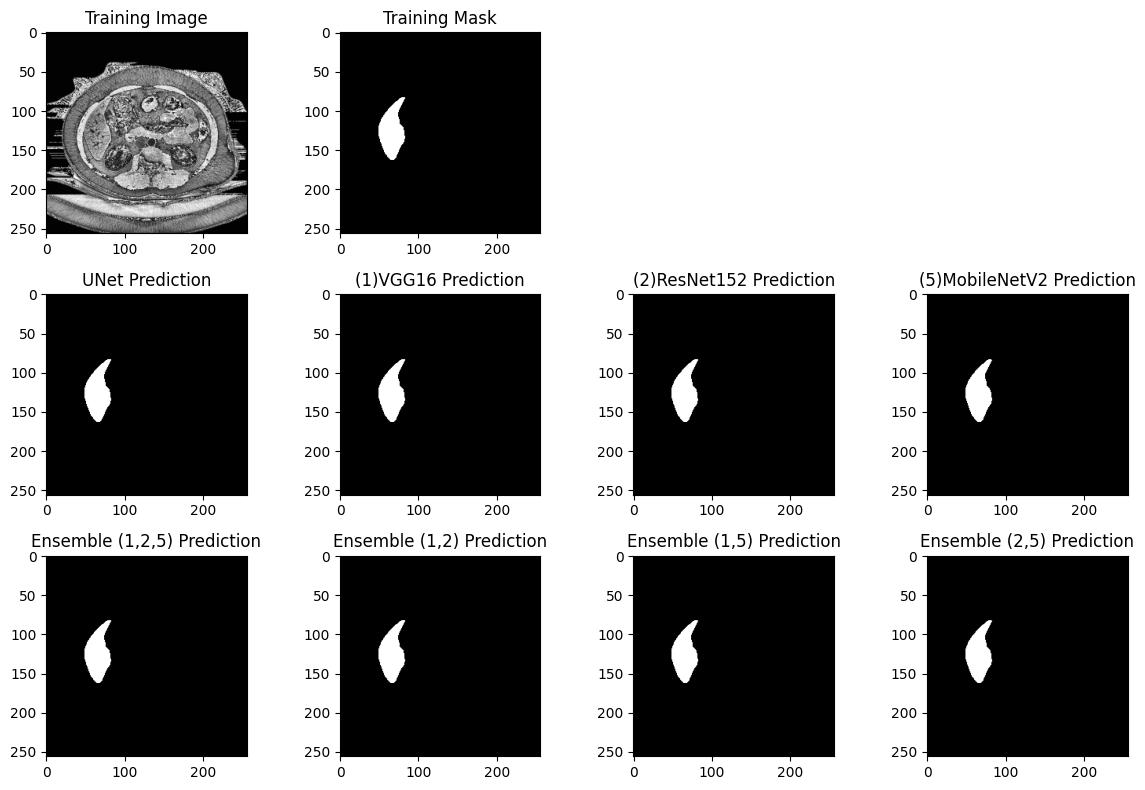

In [ ]:
index_train = random.randint(0, len(X_train))

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.title('Training Image')
plt.imshow(X_train [index_train], cmap='gray')
plt.subplot(342)
plt.title('Training Mask')
plt.imshow(Y_train [index_train], cmap='gray')

plt.subplot(345)
plt.title('UNet Prediction')
plt.imshow(preds_train4_t [index_train], cmap='gray')
plt.subplot(346)
plt.title('(1)VGG16 Prediction')
plt.imshow(preds_train1_t [index_train], cmap='gray')
plt.subplot(347)
plt.title('(2)ResNet152 Prediction')
plt.imshow(preds_train2_t [index_train], cmap='gray')
plt.subplot(348)
plt.title('(5)MobileNetV2 Prediction')
plt.imshow(preds_train5_t [index_train], cmap='gray')

plt.subplot(349)
plt.title('Ensemble (1,2,5) Prediction')
plt.imshow(weighted_train_preds[index_train], cmap='gray')
plt.subplot(3,4,10)
plt.title('Ensemble (1,2) Prediction')
plt.imshow(weighted_train_preds12[index_train], cmap='gray')
plt.subplot(3,4,11)
plt.title('Ensemble (1,5) Prediction')
plt.imshow(weighted_train_preds15[index_train], cmap='gray')
plt.subplot(3,4,12)
plt.title('Ensemble (2,5) Prediction')
plt.imshow(weighted_train_preds25[index_train], cmap='gray')

plt.tight_layout()
plt.show()

2. Validation Data

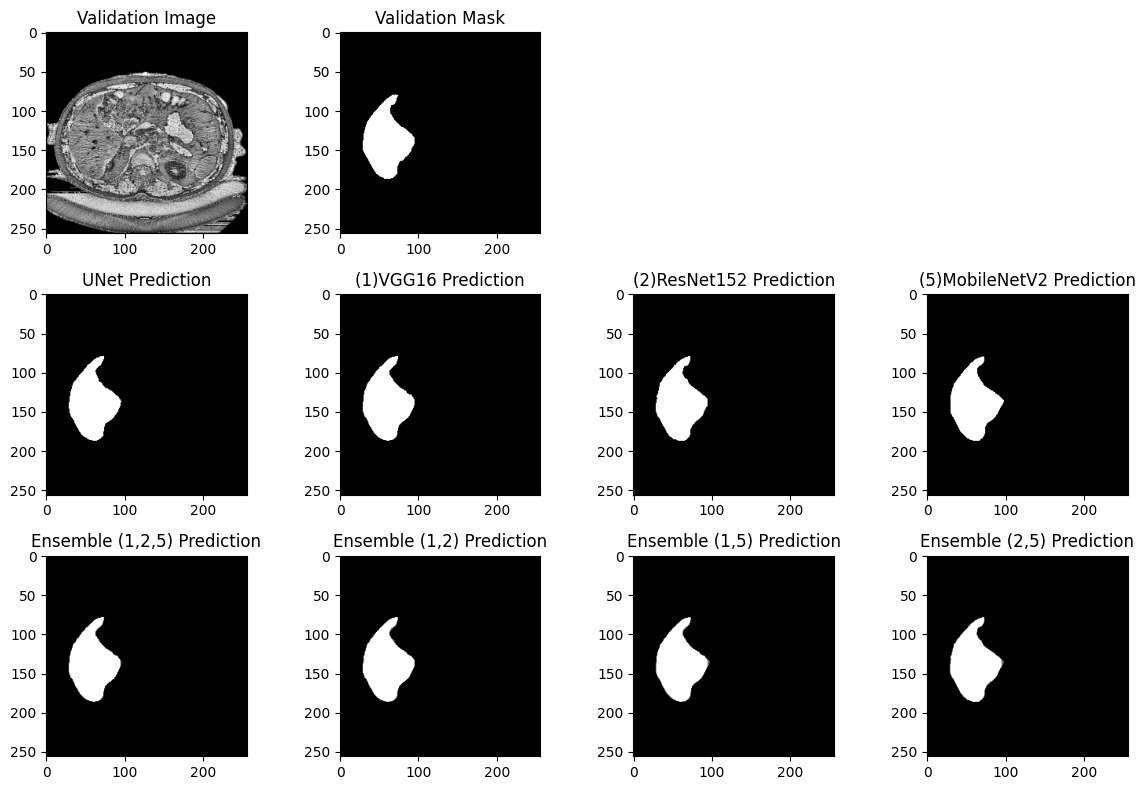

In [ ]:
index_val = random.randint(0, len(X_val))

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.title('Validation Image')
plt.imshow(X_val [index_val], cmap='gray')
plt.subplot(342)
plt.title('Validation Mask')
plt.imshow(Y_val [index_val], cmap='gray')

plt.subplot(345)
plt.title('UNet Prediction')
plt.imshow(preds_val4_t [index_val], cmap='gray')
plt.subplot(346)
plt.title('(1)VGG16 Prediction')
plt.imshow(preds_val1_t [index_val], cmap='gray')
plt.subplot(347)
plt.title('(2)ResNet152 Prediction')
plt.imshow(preds_val2_t [index_val], cmap='gray')
plt.subplot(348)
plt.title('(5)MobileNetV2 Prediction')
plt.imshow(preds_val5_t [index_val], cmap='gray')

plt.subplot(349)
plt.title('Ensemble (1,2,5) Prediction')
plt.imshow(weighted_val_preds[index_val], cmap='gray')
plt.subplot(3,4,10)
plt.title('Ensemble (1,2) Prediction')
plt.imshow(weighted_val_preds12[index_val], cmap='gray')
plt.subplot(3,4,11)
plt.title('Ensemble (1,5) Prediction')
plt.imshow(weighted_val_preds15[index_val], cmap='gray')
plt.subplot(3,4,12)
plt.title('Ensemble (2,5) Prediction')
plt.imshow(weighted_val_preds25[index_val], cmap='gray')

plt.tight_layout()
plt.show()

3. Testing Data

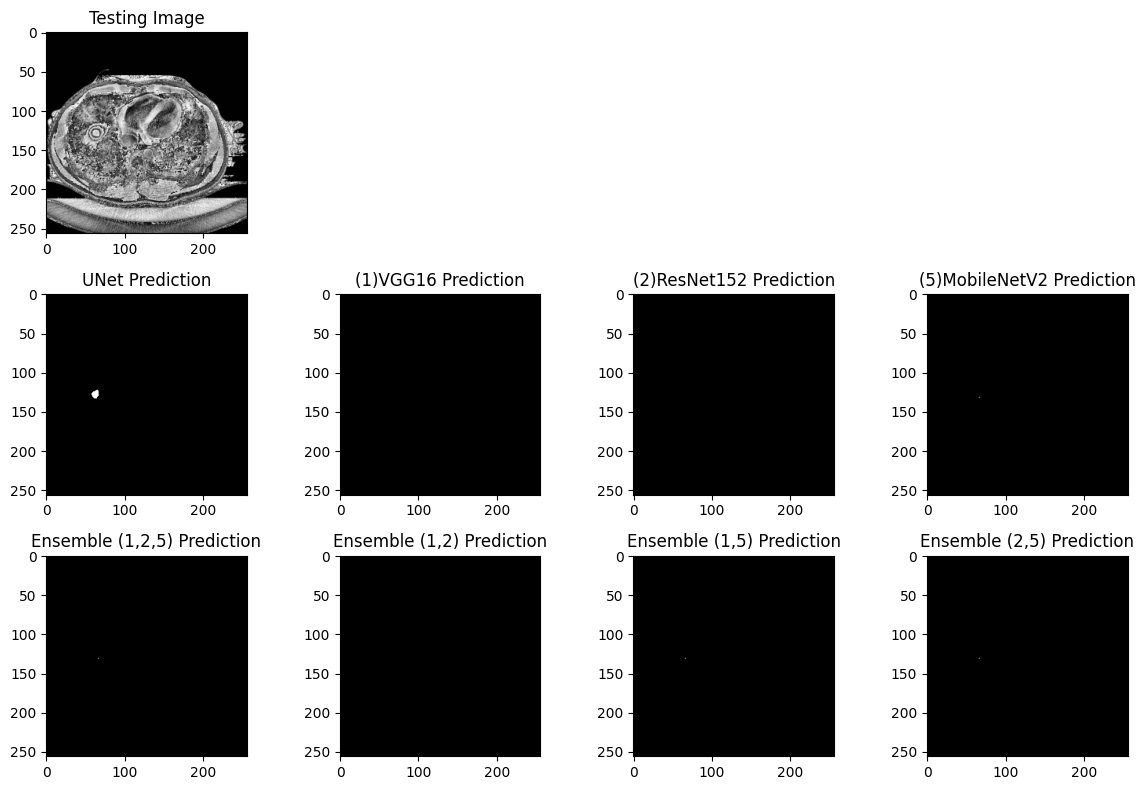

In [ ]:
index_test = random.randint(0, len(test_images_rgb))

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.title('Testing Image')
plt.imshow(test_images [index_test], cmap='gray')

plt.subplot(345)
plt.title('UNet Prediction')
plt.imshow(preds_test4_t [index_test], cmap='gray')
plt.subplot(346)
plt.title('(1)VGG16 Prediction')
plt.imshow(preds_test1_t [index_test], cmap='gray')
plt.subplot(347)
plt.title('(2)ResNet152 Prediction')
plt.imshow(preds_test2_t [index_test], cmap='gray')
plt.subplot(348)
plt.title('(5)MobileNetV2 Prediction')
plt.imshow(preds_test5_t [index_test], cmap='gray')

plt.subplot(349)
plt.title('Ensemble (1,2,5) Prediction')
plt.imshow(weighted_test_preds[index_test], cmap='gray')
plt.subplot(3,4,10)
plt.title('Ensemble (1,2) Prediction')
plt.imshow(weighted_test_preds12[index_test], cmap='gray')
plt.subplot(3,4,11)
plt.title('Ensemble (1,5) Prediction')
plt.imshow(weighted_test_preds15[index_test], cmap='gray')
plt.subplot(3,4,12)
plt.title('Ensemble (2,5) Prediction')
plt.imshow(weighted_test_preds25[index_test], cmap='gray')

plt.tight_layout()
plt.show()

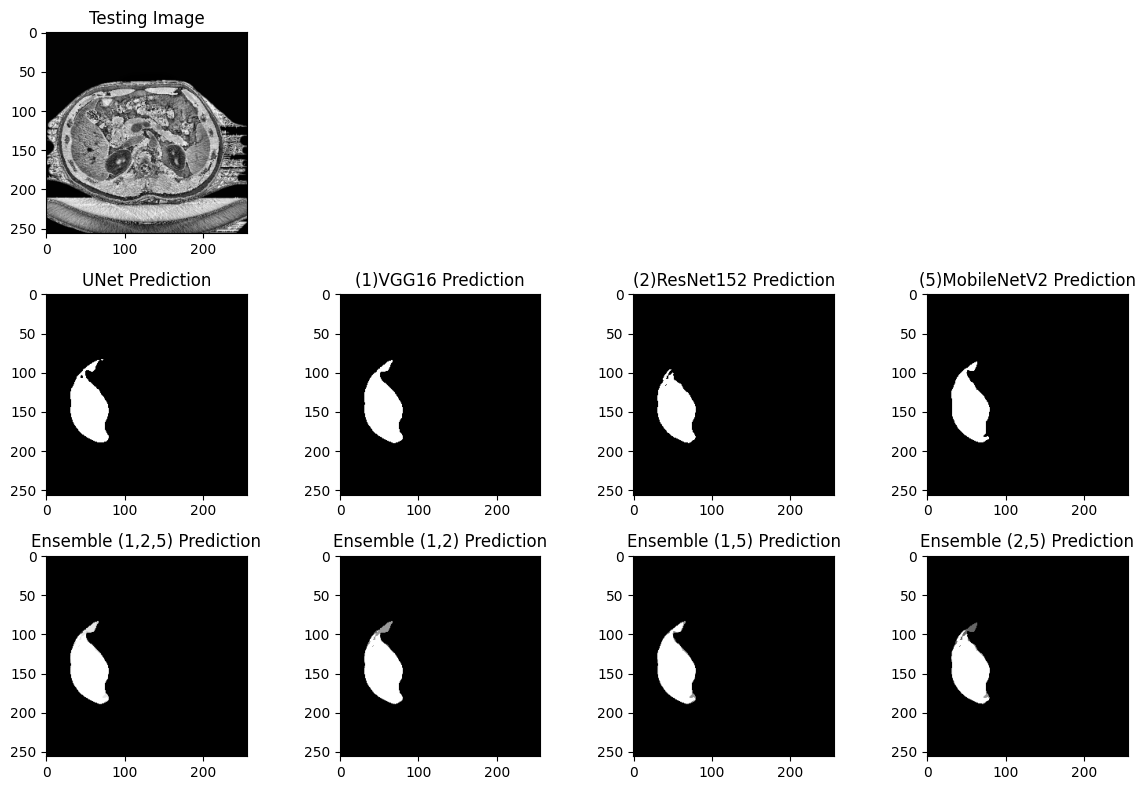

In [ ]:
index_test = random.randint(0, len(test_images_rgb))

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.title('Testing Image')
plt.imshow(test_images [index_test], cmap='gray')

plt.subplot(345)
plt.title('UNet Prediction')
plt.imshow(preds_test4_t [index_test], cmap='gray')
plt.subplot(346)
plt.title('(1)VGG16 Prediction')
plt.imshow(preds_test1_t [index_test], cmap='gray')
plt.subplot(347)
plt.title('(2)ResNet152 Prediction')
plt.imshow(preds_test2_t [index_test], cmap='gray')
plt.subplot(348)
plt.title('(5)MobileNetV2 Prediction')
plt.imshow(preds_test5_t [index_test], cmap='gray')

plt.subplot(349)
plt.title('Ensemble (1,2,5) Prediction')
plt.imshow(weighted_test_preds[index_test], cmap='gray')
plt.subplot(3,4,10)
plt.title('Ensemble (1,2) Prediction')
plt.imshow(weighted_test_preds12[index_test], cmap='gray')
plt.subplot(3,4,11)
plt.title('Ensemble (1,5) Prediction')
plt.imshow(weighted_test_preds15[index_test], cmap='gray')
plt.subplot(3,4,12)
plt.title('Ensemble (2,5) Prediction')
plt.imshow(weighted_test_preds25[index_test], cmap='gray')

plt.tight_layout()
plt.show()

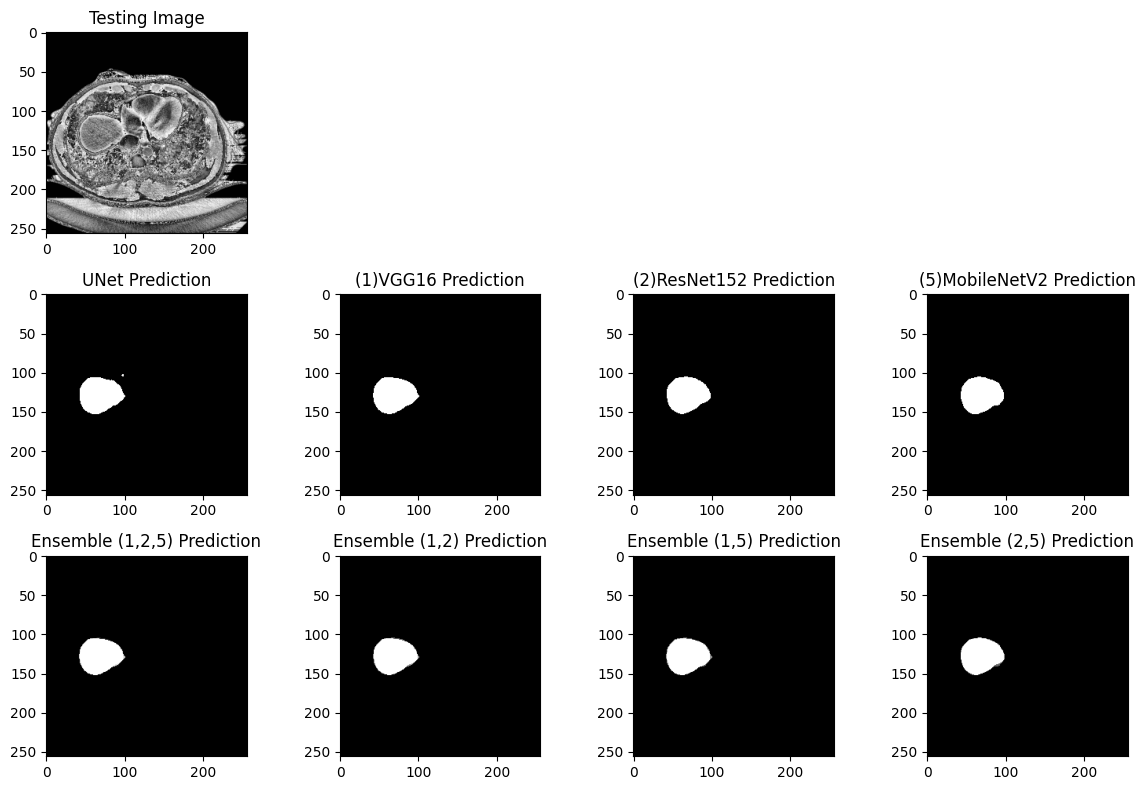

In [ ]:
index_test = random.randint(0, len(test_images_rgb))

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.title('Testing Image')
plt.imshow(test_images [index_test], cmap='gray')

plt.subplot(345)
plt.title('UNet Prediction')
plt.imshow(preds_test4_t [index_test], cmap='gray')
plt.subplot(346)
plt.title('(1)VGG16 Prediction')
plt.imshow(preds_test1_t [index_test], cmap='gray')
plt.subplot(347)
plt.title('(2)ResNet152 Prediction')
plt.imshow(preds_test2_t [index_test], cmap='gray')
plt.subplot(348)
plt.title('(5)MobileNetV2 Prediction')
plt.imshow(preds_test5_t [index_test], cmap='gray')

plt.subplot(349)
plt.title('Ensemble (1,2,5) Prediction')
plt.imshow(weighted_test_preds[index_test], cmap='gray')
plt.subplot(3,4,10)
plt.title('Ensemble (1,2) Prediction')
plt.imshow(weighted_test_preds12[index_test], cmap='gray')
plt.subplot(3,4,11)
plt.title('Ensemble (1,5) Prediction')
plt.imshow(weighted_test_preds15[index_test], cmap='gray')
plt.subplot(3,4,12)
plt.title('Ensemble (2,5) Prediction')
plt.imshow(weighted_test_preds25[index_test], cmap='gray')

plt.tight_layout()
plt.show()

Sanity Check For Ensemble Model (Single Sample)

In [ ]:
###VGG16,RES152,MOBV2
opt_weights = [0.7,0.2,0.1]

#Predict on a few images
#Random images
import random
train_img_number = random.randint(0, len(X_train_rgb))
train_img = X_train_rgb[train_img_number]
ground_truth=Y_train[train_img_number]
train_img_norm=train_img[:,:,:]
train_img_input=np.expand_dims(train_img_norm,0)

train_img_input1 = preprocess_input1(train_img_input)
train_img_input2 = preprocess_input2(train_img_input)
train_img_input5 = preprocess_input5(train_img_input)

#Prediction
final1 = model1.predict(train_img_input1, verbose=1)
final1_t = (final1 > 0.7).astype(np.uint8)

final2 = model2.predict(train_img_input2, verbose=1)
final2_t = (final2 > 0.7).astype(np.uint8)

final4 = model4.predict(train_img_input, verbose=1)
final4_t = (final4 > 0.7).astype(np.uint8)

final5 = model5.predict(train_img_input5, verbose=1)
final5_t = (final5 > 0.7).astype(np.uint8)

prediction=np.array([final1, final2, final5])
prediction_t=np.array([final1_t, final2_t, final5_t])
weighted_train_prediction = np.tensordot(prediction_t, opt_weights, axes=((0),(0)))
weighted_ensemble_train_prediction = np.argmax(weighted_train_prediction, axis=3)

###VGG16,RES152
opt_weights12 = [0.7,0.3]

predictions12=np.array([final1, final2])
prediction_t12=np.array([final1_t, final2_t])
weighted_train_prediction12 = np.tensordot(prediction_t12, opt_weights12, axes=((0),(0)))
weighted_ensemble_train_prediction12 = np.argmax(weighted_train_prediction12, axis=3)

###VGG16,MOBV2
opt_weights15 = [0.7,0.3]

prediction15=np.array([final1, final5])
prediction_t15=np.array([final1_t, final5_t])

#Use tensordot to sum the products of all elements over specified axes.
weighted_train_prediction15 = np.tensordot(prediction_t15, opt_weights15, axes=((0),(0)))
weighted_ensemble_train_prediction15 = np.argmax(weighted_train_prediction15, axis=3)

###RES152,MOBV2
opt_weights25 = [0.7,0.3]

prediction25=np.array([final2, final5])
prediction_t25=np.array([final2_t, final5_t])

#Use tensordot to sum the products of all elements over specified axes.
weighted_train_prediction25 = np.tensordot(prediction_t25, opt_weights25, axes=((0),(0)))
weighted_ensemble_train_prediction25 = np.argmax(weighted_train_prediction25, axis=3)

1/1 [==============================] - 0s 21ms/step


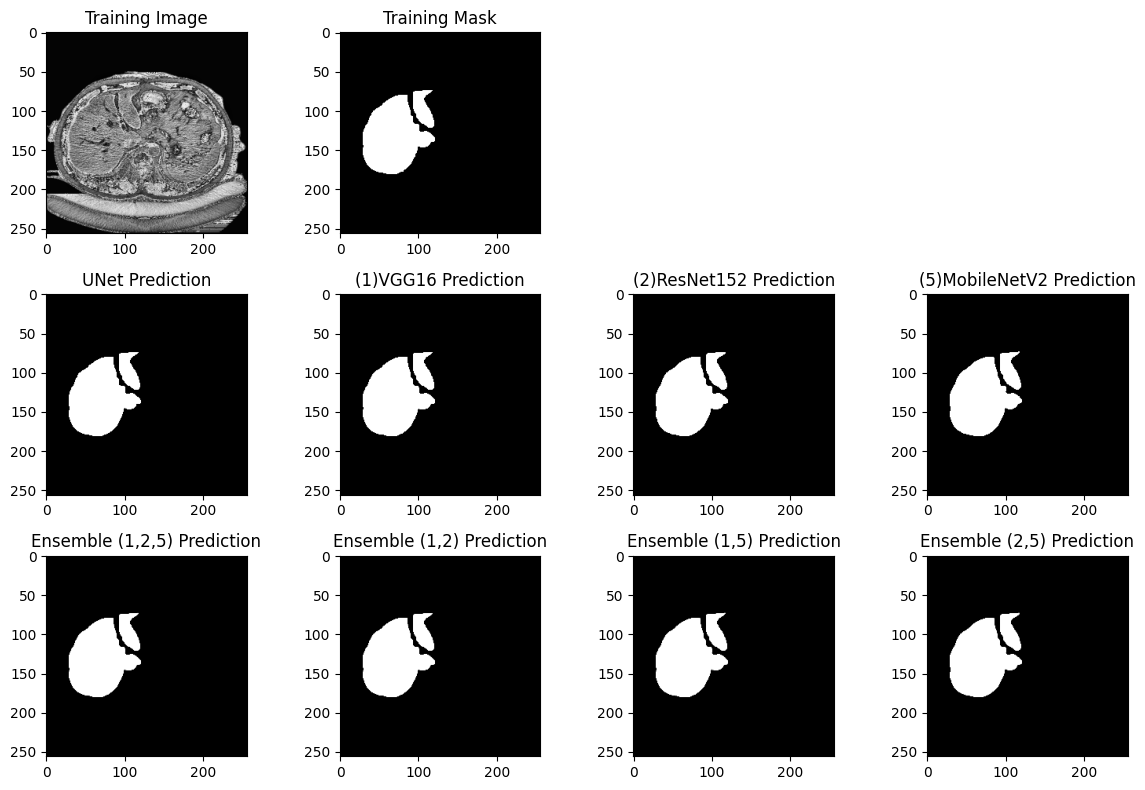

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.title('Training Image')
plt.imshow(train_img, cmap='gray')
plt.subplot(342)
plt.title('Training Mask')
plt.imshow(ground_truth, cmap='gray')

plt.subplot(345)
plt.title('UNet Prediction')
plt.imshow(final4_t.squeeze(axis=-1)[0], cmap='gray')
plt.subplot(346)
plt.title('(1)VGG16 Prediction')
plt.imshow(final1_t.squeeze(axis=-1)[0], cmap='gray')
plt.subplot(347)
plt.title('(2)ResNet152 Prediction')
plt.imshow(final2_t.squeeze(axis=-1)[0], cmap='gray')
plt.subplot(348)
plt.title('(5)MobileNetV2 Prediction')
plt.imshow(final5_t.squeeze(axis=-1)[0], cmap='gray')

plt.subplot(349)
plt.title('Ensemble (1,2,5) Prediction')
plt.imshow(weighted_train_prediction[0, :, :, 0], cmap='gray')
plt.subplot(3,4,10)
plt.title('Ensemble (1,2) Prediction')
plt.imshow(weighted_train_prediction12[0, :, :, 0], cmap='gray')
plt.subplot(3,4,11)
plt.title('Ensemble (1,5) Prediction')
plt.imshow(weighted_train_prediction15[0, :, :, 0], cmap='gray')
plt.subplot(3,4,12)
plt.title('Ensemble (2,5) Prediction')
plt.imshow(weighted_train_prediction25[0, :, :, 0], cmap='gray')

plt.tight_layout()
plt.show()

Objective|IOU Check For Ensemble Model (Single Sample)

In [ ]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection)/np.sum(union)
    return iou_score

In [ ]:
iou4 = calculate_iou(ground_truth, final4_t)
iou1 = calculate_iou(ground_truth, final1_t)
iou2 = calculate_iou(ground_truth, final2_t)
iou5 = calculate_iou(ground_truth, final5_t)
iou = calculate_iou(ground_truth, weighted_train_prediction)
iou12 = calculate_iou(ground_truth, weighted_train_prediction12)
iou15 = calculate_iou(ground_truth, weighted_train_prediction15)
iou25 = calculate_iou(ground_truth, weighted_train_prediction25)

data = [
    ["Model UNet", iou4],
    ["Model 1 (VGG16)", iou1],
    ["Model 2 (ResNet152)", iou2],
    ["Model 5 (MobileNetV2)", iou5],
    ["Ensemble Prediction", iou],
    ["Ensemble Prediction 12", iou12],
    ["Ensemble Prediction 15", iou15],
    ["Ensemble Prediction 25", iou25],
]

print(tabulate(data, headers=["Model", "IoU Score"], tablefmt="grid"))

+------------------------+-------------+
| Model                  |   IoU Score |
+========================+=============+
| Model UNet             |    0.995379 |
+------------------------+-------------+
| Model 1 (VGG16)        |    0.997616 |
+------------------------+-------------+
| Model 2 (ResNet152)    |    0.993595 |
+------------------------+-------------+
| Model 5 (MobileNetV2)  |    0.992112 |
+------------------------+-------------+
| Ensemble Prediction    |    0.996136 |
+------------------------+-------------+
| Ensemble Prediction 12 |    0.997767 |
+------------------------+-------------+
| Ensemble Prediction 15 |    0.996579 |
+------------------------+-------------+
| Ensemble Prediction 25 |    0.994646 |
+------------------------+-------------+
